## Dask example


In [0]:
!pip install "dask[complete]"    # Install everything

In [0]:
from dask.delayed import delayed
import dask
dask.config.set(scheduler='processes')

T = np.random.rand(2) * 1000 + 1001
# n_s = np.random.rand(30) * 30 + 0.1
# n_l = np.random.rand(30) * 30
n_s = np.linspace(0, 8, 20)
n_l = np.linspace(0, 30, 30)

n = np.unique(np.concatenate((n_s, n_l)))[1:]
n = n[n > 0.4]
XX, YY = np.meshgrid(T, n)
ini = np.concatenate((XX.reshape(-1, 1), YY.reshape(-1, 1)), axis=1)
# print(ini)

dask.config.set(scheduler='processes')


a = [delayed(ignite_f)([x[0], x[1], 'H2']) for x in ini]
a = dask.compute(*a)

print('There are {} sets.'.format(len(a)))

In [0]:
org=np.concatenate([x[0] for x in a])
new=np.concatenate([x[1] for x in a])

import pandas as pd
gas = ct.Solution('./data/h2_sandiego.cti')
columnNames = gas.species_names
columnNames = columnNames + ['Hs']
columnNames = columnNames + ['T']
columnNames = columnNames + ['Rho']
columnNames = columnNames + ['cp']
columnNames = columnNames + ['dt']
columnNames = columnNames + ['f']

train_org = pd.DataFrame(data=org, columns=columnNames)
train_new = pd.DataFrame(data=new, columns=columnNames)

## Install cantera

In [0]:
!wget https://anaconda.org/Cantera/cantera/2.4.0/download/linux-64/cantera-2.4.0-np115py36_2.tar.bz2
!tar xjf cantera-2.4.0-np115py36_2.tar.bz2
!cp -r lib/python3.6/site-packages/*  /usr/local/lib/python3.6/dist-packages/

--2019-05-06 14:09:41--  https://anaconda.org/Cantera/cantera/2.4.0/download/linux-64/cantera-2.4.0-np115py36_2.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/57ae953efe7dbe71ce32d2f9/5b8020f7c036d81345393b8d?response-content-disposition=attachment%3B%20filename%3D%22cantera-2.4.0-np115py36_2.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27cantera-2.4.0-np115py36_2.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20190506T140942Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=AgoJb3JpZ2luX2VjEB0aCXVzLWVhc3QtMSJIMEYCIQCm2WFDNlgcSKZDNZNzfkq3DVMkM6pXAeN5VAyHPTTD5wIhAMuz4sUmkCZfISbz1oV8TKCmoSmUH19ekZ%2BzBcDVoBN0KtoDCBYQABoMNDU1ODY0MDk4Mzc4IgyhmsfMAQ7W4R3mzREqtwN%2Fl0TJQqp9v7rBAkEVyc71YRfWoHUJCa1m1Mz7

In [0]:
!mkdir data
%cd ./data
!wget https://raw.githubusercontent.com/uqyge/cantera/master/data/h2_sandiego.cti
%cd ..

/content/data
--2019-05-06 14:09:48--  https://raw.githubusercontent.com/uqyge/cantera/master/data/h2_sandiego.cti
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9432 (9.2K) [text/plain]
Saving to: ‘h2_sandiego.cti’

h2_sandiego.cti     100%[===================>]   9.21K  --.-KB/s    in 0s      

2019-05-06 14:09:48 (129 MB/s) - ‘h2_sandiego.cti’ saved [9432/9432]

/content


In [0]:
"""
Solve a constant pressure ignition problem where the governing equations are
implemented in Python.

This demonstrates an approach for solving problems where Cantera's reactor
network model cannot be configured to describe the system in question. Here,
Cantera is used for evaluating thermodynamic properties and kinetic rates while
an external ODE solver is used to integrate the resulting equations. In this
case, the SciPy wrapper for VODE is used, which uses the same variable-order BDF
methods as the Sundials CVODES solver used by Cantera.
"""

import cantera as ct
import numpy as np
import scipy.integrate

class ReactorOde:
    def __init__(self, gas):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.P = gas.P

    def __call__(self, t, y):
        """the ODE function, y' = f(t,y) """

        # State vector is [T, Y_1, Y_2, ... Y_K]
        self.gas.set_unnormalized_mass_fractions(y[1:])
        self.gas.TP = y[0], self.P
        rho = self.gas.density

        wdot = self.gas.net_production_rates
        dTdt = - (np.dot(self.gas.partial_molar_enthalpies, wdot) /
                  (rho * self.gas.cp))
        dYdt = wdot * self.gas.molecular_weights / rho

        return np.hstack((dTdt, dYdt))

def ignite_f(ini):
    temp = ini[0]
    n_fuel = ini[1]
    fuel = ini[2]

    train_org = []
    train_new = []

    t_end = 1e-3

    # dt_dict = [5e-7, 7e-7, 1e-6, 1.5e-6]
    # dt_dict = [0.8e-6, 1e-6, 1.2e-6]
    dt_dict = [1e-6,1e-6,1e-6]
    for dt in dt_dict:
        if fuel == 'H2':
            # gas = ct.Solution('./data/Boivin_newTherm.cti')
            gas = ct.Solution('./data/h2_sandiego.cti')
        if fuel == 'CH4':
            gas = ct.Solution('./data/grimech12.cti')
            # gas = ct.Solution('gri30.xml')
        P = ct.one_atm

        gas.TPX = temp, P, fuel + ':' + str(n_fuel) + ',O2:1,N2:4'
        y0 = np.hstack((gas.T, gas.Y))
        ode = ReactorOde(gas)
        solver = scipy.integrate.ode(ode)
        solver.set_integrator('vode', method='bdf', with_jacobian=True)
        solver.set_initial_value(y0, 0.0)
        dt_base = dt
        while solver.successful() and solver.t < t_end:

            if solver.t == 0:
                dt_ini = np.random.random_sample() * 1e-6
                solver.integrate(solver.t + dt_ini)

            dt = dt_base * (0.9+round(0.2*np.random.random(),2))
            state_org = np.hstack(
                [gas[gas.species_names].concentrations, np.dot(gas.partial_molar_enthalpies, gas[gas.species_names].X),
                 gas.T, gas.density, gas.cp, dt, n_fuel])

            solver.integrate(solver.t + dt)

            gas.TPY = solver.y[0], P, solver.y[1:]

            # Extract the state of the reactor
            state_new = np.hstack(
                [gas[gas.species_names].concentrations, np.dot(gas.partial_molar_enthalpies, gas[gas.species_names].X),
                 gas.T, gas.density, gas.cp, dt, n_fuel])

            # state_new = np.hstack([gas[gas.species_names].Y])
            state_res = state_new - state_org
            res = abs(state_res[:-2][state_org[:-2] != 0] / state_org[:-2][state_org[:-2] != 0])/dt

            # res[res==np.inf]=0
            # res = np.nan_to_num(res)
            # res=res[res!=0]
            # print(res.max())

            # Update the sample
            train_org.append(state_org)
            train_new.append(state_new)

            # if (abs(state_res.max() / state_org.max()) < 1e-5 and (solver.t / dt) > 200):
            if ((res.max() < 1e-3 and (solver.t / dt) > 50)) or (gas['H2'].X < 0.005 or gas['H2'].X > 0.995):
                # if res.max() < 1e-5:
                break

    return train_org, train_new

### Testing data generation

In [0]:
def ignite_post(ini):
    temp = ini[0]
    n_fuel = ini[1]
    fuel = ini[2]

    train_org = []
    train_new = []

    t_end = 1e-3

    # dt_dict = [5e-7, 7e-7, 1e-6, 1.5e-6]
    # dt_dict = [0.8e-6, 1e-6, 1.2e-6]
    dt_dict = [ini[3]]
    for dt in dt_dict:
        if fuel == 'H2':
            # gas = ct.Solution('./data/Boivin_newTherm.cti')
            gas = ct.Solution('./data/h2_sandiego.cti')
        if fuel == 'CH4':
            gas = ct.Solution('./data/grimech12.cti')
            # gas = ct.Solution('gri30.xml')
        P = ct.one_atm

        gas.TPX = temp, P, fuel + ':' + str(n_fuel) + ',O2:1,N2:4'
        y0 = np.hstack((gas.T, gas.Y))
        ode = ReactorOde(gas)
        solver = scipy.integrate.ode(ode)
        solver.set_integrator('vode', method='bdf', with_jacobian=True)
        solver.set_initial_value(y0, 0.0)
#         dt_base = dt
        while solver.successful() and solver.t < t_end:

            if solver.t == 0:
#                 dt_ini = np.random.random_sample() * 1e-6
                dt_ini = 1e-6
                solver.integrate(solver.t + dt_ini)

#             dt = dt_base * (0.9+round(0.2*np.random.random(),2))
            state_org = np.hstack(
                [gas[gas.species_names].concentrations, np.dot(gas.partial_molar_enthalpies, gas[gas.species_names].X),
                 gas.T, gas.density, gas.cp, dt, n_fuel])

            solver.integrate(solver.t + dt)

            gas.TPY = solver.y[0], P, solver.y[1:]

            # Extract the state of the reactor
            state_new = np.hstack(
                [gas[gas.species_names].concentrations, np.dot(gas.partial_molar_enthalpies, gas[gas.species_names].X),
                 gas.T, gas.density, gas.cp, dt, n_fuel])

            # state_new = np.hstack([gas[gas.species_names].Y])
            state_res = state_new - state_org
            res = abs(state_res[:-2][state_org[:-2] != 0] / state_org[:-2][state_org[:-2] != 0])/dt

            # res[res==np.inf]=0
            # res = np.nan_to_num(res)
            # res=res[res!=0]
            # print(res.max())

            # Update the sample
            train_org.append(state_org)
            train_new.append(state_new)

            # if (abs(state_res.max() / state_org.max()) < 1e-5 and (solver.t / dt) > 200):
            if ((res.max() < 1e-3 and (solver.t / dt) > 50)) or (gas['H2'].X < 0.005 or gas['H2'].X > 0.995):
                # if res.max() < 1e-5:
                print(res)
                break

    return train_org, train_new
  
def test_data(temp, n_fuel, columns , dt):
    # temp = 1501
    # n_fuel = 4
    ode_o, ode_n = ignite_post((temp, n_fuel, 'H2', dt))
    ode_o = np.asarray(ode_o)
    ode_n = np.asarray(ode_n)

#     ode_o = np.append(ode_o, n_fuel * np.ones((ode_o.shape[0], 1)), axis=1)
#     ode_n = np.append(ode_n, n_fuel * np.ones((ode_n.shape[0], 1)), axis=1)
    ode_o = pd.DataFrame(data=ode_o,
                         columns=columns)
    ode_n = pd.DataFrame(data=ode_n,
                         columns=columns)
    idx_test=(ode_o>1e-9).all(1)
    ode_o=ode_o[idx_test]
    ode_n=ode_n[idx_test]

    return ode_o, ode_n

## Load data

In [0]:
!pip install gdown
!mkdir ./data
import gdown

def data_import():
  ids = {
      "merged.h5":"18zrRO9AqdadW1fdBM7a7ZjKP-mhPu15Q",
#       "merged.h5":"1drUJ0S4kAe1wuWu8Zx446jxScmLLVee_",
#       "dydt.h5":"1-LaNMN7KiHe92I6UQ9rg-OJah-1Z6vqJ"
  }

  url = 'https://drive.google.com/uc?id='

  for title, g_id in ids.items(): 
    try:
      output_file = open("/content/data/" + title, 'wb')
      gdown.download(url + g_id, output_file, quiet=False)
    except IOError as e:
      print(e, file=sys.stderr)
    finally:
      output_file.close()
      
data_import()

mkdir: cannot create directory ‘./data’: File exists


Downloading...
From: https://drive.google.com/uc?id=18zrRO9AqdadW1fdBM7a7ZjKP-mhPu15Q
To: <_io.BufferedWriter name='/content/data/merged.h5'>
1.27GB [00:07, 168MB/s]


In [0]:
import pandas as pd
df_dydt = pd.read_hdf('data/dydt.h5')
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()
dydt=scl.fit_transform(df_dydt)
dydt=pd.DataFrame(dydt,columns=['T']+gas.species_names)
dydt.describe()
plt.hist(dydt['H2O2'])

In [0]:
import pandas as pd
df_load = pd.read_hdf('data/merged.h5')
df=df_load.astype('float32',copy=True)
# df=df_load
print(df.shape)
org=df[0:int(df.shape[0]/2)].reset_index(drop=True)
new=df[int(df.shape[0]/2):].reset_index(drop=True)
org.columns

(15272512, 15)


Index(['H2', 'H', 'O2', 'OH', 'O', 'H2O', 'HO2', 'H2O2', 'N2', 'Hs', 'T',
       'Rho', 'cp', 'dt', 'f'],
      dtype='object')

In [0]:
idx_dt=(org['dt']<5e-7)&(org['dt']>5e-9)
print(sum(idx_dt))
org=org[idx_dt]
new=new[idx_dt]
# org['HO2']=org['HO2']*1e3
# new['HO2']=new['HO2']*1e3

7636256


In [0]:
idx=(org>1e-15).all(1)
print(sum(idx))
org=org[idx]
new=new[idx]

7632761


In [0]:
idx_f=((new/org)<5).all(1)
print(sum(idx_f))
org=org[idx_f]
new=new[idx_f]

7632671


### focus on 'tails'

In [0]:
idx_f=(abs((new-org).div(org.dt,axis=0))<1).all(1)
print(sum(idx_f))
org=org[idx_f]
new=new[idx_f]

28


In [0]:
org=org.reset_index(drop=True)
new=new.reset_index(drop=True)

id_test=21
if new['H'][id_test]-org['H'][id_test+1]==0:
  print('Data loading is successful.')
  org.describe()

Data loading is successful.


In [0]:
((new-org).div(org.dt,axis=0)).describe()

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp,dt,f
count,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7.632671e+06,7632671.0,7.632671e+06
mean,-2.738279e+00,1.204898e-01,-7.798998e-01,4.491902e-02,1.364321e-02,9.342179e-01,6.456104e-06,1.850753e-06,-1.146753e+00,3.027999e+09,1.048002e+06,-4.471298e+01,2.433771e+05,0.0,1.000000e+00
std,2.722260e+01,1.244809e+01,9.795217e+00,1.513103e+00,1.705582e+00,1.449302e+01,4.109208e-03,6.549062e-04,8.450027e+00,1.404647e+10,4.996645e+06,3.190791e+02,1.143070e+06,0.0,1.827764e-04
min,-1.256522e+03,-9.151865e+01,-5.448934e+02,-1.309832e+00,-1.206887e+01,-2.952318e+01,-1.355380e-01,-1.148049e-02,-2.908055e+02,-1.061224e+09,-3.923512e+06,-1.078141e+04,-5.214654e+04,0.0,9.988434e-01
25%,-2.686507e-01,-2.106461e-01,-1.161057e-04,-4.982915e-03,-3.592020e-04,-3.911805e-02,-5.456393e-08,-6.103335e-08,-1.411095e-01,2.061856e+07,5.033828e+03,-6.154828e+00,0.000000e+00,0.0,9.999052e-01
50%,-5.628873e-02,-4.394972e-02,-3.514513e-06,-8.750607e-04,-2.856974e-05,-7.814918e-03,-2.585078e-09,-4.674116e-09,-2.550050e-02,1.720430e+08,5.768158e+04,-1.135327e+00,1.743862e+04,0.0,1.000002e+00
75%,-2.328306e-03,-1.212660e-03,-3.505826e-07,-1.281561e-04,-4.228501e-06,0.000000e+00,-2.599740e-10,-5.963112e-10,-2.503556e-03,8.913043e+08,2.910908e+05,-1.128876e-01,7.961107e+04,0.0,1.000084e+00
max,9.494065e-02,6.884761e+02,1.225424e-03,1.795158e+02,2.061768e+02,7.815696e+02,1.552320e-01,5.039962e-02,8.646775e+00,3.342056e+11,1.194002e+08,3.131978e+02,3.053836e+07,0.0,1.001172e+00


In [0]:
!pip install gdown
!mkdir ./data
import gdown

def data_import():
  ids = {
      "org.h5":"1drUJ0S4kAe1wuWu8Zx446jxScmLLVee_",
      "dydt.h5":"1-LaNMN7KiHe92I6UQ9rg-OJah-1Z6vqJ"
  }

  url = 'https://drive.google.com/uc?id='

  for title, g_id in ids.items(): 
    try:
      output_file = open("/content/data/" + title, 'wb')
      gdown.download(url + g_id, output_file, quiet=False)
    except IOError as e:
      print(e, file=sys.stderr)
    finally:
      output_file.close()
      
data_import()

In [0]:
import pandas as pd
org = pd.read_hdf('data/org.h5')
dydt = pd.read_hdf('data/dydt.h5')

idx=(org>1e-15).all(1)
print(sum(idx))
org=org[idx]
dydt=dydt[idx]


## Prepare network

### Resblock and scaling

In [0]:
import tensorflow as tf
import keras
from keras.layers import Dense, Activation, Input, BatchNormalization, Dropout, concatenate
from keras import layers

def res_branch(bi, conv_name_base, bn_name_base, scale, input_tensor, n_neuron, stage, block,dp1, bn=False):
    x_1 = Dense(scale * n_neuron, name=conv_name_base + '2a_'+str(bi))(input_tensor)
    if bn:
        x_1 = BatchNormalization(axis=-1, name=bn_name_base + '2a_'+str(bi))(x_1)
    x_1 = Activation('relu')(x_1)
    if dp1>0:
      x_1 = Dropout(dp1)(x_1)
    return x_1

def res_block(input_tensor,scale, n_neuron, stage, block, bn=False,branches=0):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

#     scale = 2
    x = Dense(scale * n_neuron, name=conv_name_base + '2a')(input_tensor)
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    dp1=0.
    if dp1 >0:
        x = Dropout(dp1)(x)
    
    branch_list=[x]
    for i in range(branches-1):
        branch_list.append(res_branch(i,conv_name_base, bn_name_base, scale,input_tensor,n_neuron,stage,block,dp1,bn))
    if branches-1 > 0:
        x = Dense(n_neuron, name=conv_name_base + '2b')(concatenate(branch_list,axis=-1))
#         x = Dense(n_neuron, name=conv_name_base + '2b')(layers.add(branch_list))
    else:
        x = Dense(n_neuron, name=conv_name_base + '2b')(x)
    
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2b')(x)
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    if dp1 >0:
        x = Dropout(dp1)(x)

    return x

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class data_scaler(object):
    def __init__(self):
        self.norm = None
        self.norm_1 = None
        self.std = None
        self.case = None
        self.scale = 1
        self.bias = 1e-20
#         self.bias = 1


        self.switcher = {
            'min_std': 'min_std',
            'std2': 'std2',
            'std_min':'std_min',
            'min': 'min',
            'no':'no',
            'log': 'log',
            'log_min':'log_min',
            'log_std':'log_std',
            'log2': 'log2',
            'sqrt_std': 'sqrt_std',
            'cbrt_std': 'cbrt_std',
            'nrt_std':'nrt_std',
            'cb_std':'cb_std',
            'tan': 'tan'
        }

    def fit_transform(self, input_data, case):
        self.case = case
        if self.switcher.get(self.case) == 'min_std':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'std2':
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'min':
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'log2':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)
            
        if self.switcher.get(self.case) == 'cb_std':
            out = np.power(np.asarray(input_data / self.scale),3)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'tan':
            self.norm = MaxAbsScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def transform(self, input_data):
        if self.switcher.get(self.case) == 'min_std':
            out = self.norm.transform(input_data)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'log2':
            out = self.norm.transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            out = self.std.transform(out)
            
        if self.switcher.get(self.case) == 'cb_std':
            out = np.power(np.asarray(input_data / self.scale),3)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def inverse_transform(self, input_data):

        if self.switcher.get(self.case) == 'min_std':
            out = self.std.inverse_transform(input_data)
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = self.norm.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log_std':
            out = self.std.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log2':
            out = self.std.inverse_transform(input_data)
            out = np.exp(out) - self.bias
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,2) * self.scale

        if self.switcher.get(self.case) == 'cbrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,3) * self.scale

        if self.switcher.get(self.case) == 'nrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,4) * self.scale
            
        if self.switcher.get(self.case) == 'cb_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,1/3) * self.scale
            
        if self.switcher.get(self.case) == 'tan':
            out = (2 * np.pi + self.bias) * np.arctan(input_data)
            out = self.norm.inverse_transform(out)
            out = self.std.inverse_transform(out)

        return out    

### build network

#### read  test

In [0]:
def read_h5_data(input_features, labels):
    input_df=org[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df[input_features].values,'std2')

#     label_df=(new[labels]-org[labels])
    label_df=((new[labels]-org[labels]).div(org.dt,axis=0))
#     label_df=(new[labels])/org[labels]
#     label_df=dydt[labels]

    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df[labels].values,'std2')
  
    return input_np, label_np, in_scaler, out_scaler

In [0]:
def read_h5_data(input_features, labels):
    input_df=org[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df[input_features].values,'std2')

#     label_df=(new[labels]-org[labels])
    label_df=((new[labels]-org[labels]).div(org.dt,axis=0))
#     label_df=(new[labels])/org[labels]
#     label_df=new[labels]

    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df[labels].values,'std2')
  
    return input_df[input_features].values, label_df[labels].values, in_scaler, out_scaler

#### split data

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# define the labels

labels = df.columns.drop(['dt','f','Hs','cp'])
# labels=['HO2']

# input_features=df.columns.drop(['f'])
input_features = labels

# read in the data
x_input, y_label, in_scaler, out_scaler = read_h5_data(input_features=input_features, labels = labels)
x_train, x_test, y_train, y_test = train_test_split(x_input,y_label, test_size=0.1)

In [0]:
y_df=pd.DataFrame(out_scaler.inverse_transform(y_label),columns=labels)

In [0]:
y_df.describe()

In [0]:
_=plt.hist(y_df['HO2'],50)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation

out_m=out_scaler.std.mean_.astype('float32')
out_s=out_scaler.std.scale_.astype('float32')
# out_m = (new[labels]-org[labels]).div(org.dt,axis=0).mean().values
# out_s = (new[labels]-org[labels]).div(org.dt,axis=0).std().values


model_inv = Sequential()
model_inv.add(Dense(len(out_m), input_dim=len(out_m), trainable=True))
model_inv.add(Activation('linear'))
model_inv.layers[0].set_weights([(out_s)*np.identity(len(out_m)),+out_m])

in_m=in_scaler.std.mean_.astype('float32')
in_s=in_scaler.std.scale_.astype('float32')
# in_m = org[labels].mean().values
# in_s = org[labels].std().values

model_trans = Sequential()
model_trans.add(Dense(len(in_m), input_dim=(len(in_m)), trainable=True))
model_trans.add(Activation('linear'))
model_trans.layers[0].set_weights([(1/in_s)*np.identity(len(in_m)),-(in_m/in_s)])

In [0]:
from keras import optimizers

batch_size = 1024*8*8
epochs = 400
vsplit = 0.1

loss_type='mse'
adam_op = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999,epsilon=1e-8, decay=0.0, amsgrad=True)
model_trans.compile(loss=loss_type, optimizer=adam_op, metrics=['accuracy'])

callbacks_list = [checkpoint]
# callbacks_list = [checkpoint, schedule]

# model.load_weights(filepath)
x_scaled = in_scaler.transform(x_input)
# fit the model
history = model_trans.fit(
    x_input, x_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)



Train on 6869403 samples, validate on 763268 samples
Epoch 1/400
 - 8s - loss: 0.0021 - acc: 0.9784 - val_loss: 2.9978e-07 - val_acc: 0.9998
Epoch 2/400
 - 8s - loss: 4.4925e-08 - acc: 0.9999 - val_loss: 6.0821e-10 - val_acc: 1.0000
Epoch 3/400
 - 7s - loss: 3.4595e-10 - acc: 1.0000 - val_loss: 5.8973e-10 - val_acc: 1.0000
Epoch 4/400
 - 8s - loss: 3.4157e-10 - acc: 1.0000 - val_loss: 5.8591e-10 - val_acc: 1.0000
Epoch 5/400
 - 7s - loss: 3.3758e-10 - acc: 1.0000 - val_loss: 5.7297e-10 - val_acc: 1.0000
Epoch 6/400
 - 8s - loss: 3.3081e-10 - acc: 1.0000 - val_loss: 5.6670e-10 - val_acc: 1.0000
Epoch 7/400
 - 8s - loss: 3.2341e-10 - acc: 1.0000 - val_loss: 5.5243e-10 - val_acc: 1.0000

Epoch 00007: val_loss improved from 0.00050 to 0.00000, saving model to ./tmp/weights.best.cntk.hdf5
Epoch 8/400
 - 8s - loss: 3.1607e-10 - acc: 1.0000 - val_loss: 5.4853e-10 - val_acc: 1.0000
Epoch 9/400
 - 7s - loss: 3.0888e-10 - acc: 1.0000 - val_loss: 5.3092e-10 - val_acc: 1.0000
Epoch 10/400
 - 8s - 

KeyboardInterrupt: ignored

In [0]:
loss_type='mse'
adam_op = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999,epsilon=1e-8, decay=0.0, amsgrad=True)
model_inv.compile(loss=loss_type, optimizer=adam_op, metrics=['accuracy'])

callbacks_list = [checkpoint]
# callbacks_list = [checkpoint, schedule]

# model.load_weights(filepath)
y_scaled = out_scaler.inverse_transform(y_label)
# fit the model
history = model_inv.fit(
    y_label, y_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)


Train on 6869403 samples, validate on 763268 samples
Epoch 1/400
 - 7s - loss: 26120801526.4141 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000
Epoch 2/400
 - 6s - loss: 26120791446.4758 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000
Epoch 3/400
 - 6s - loss: 26120791505.7332 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000
Epoch 4/400
 - 6s - loss: 26120791488.5127 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000
Epoch 5/400
 - 6s - loss: 26120791273.1058 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/400
 - 6s - loss: 26120791515.9016 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000
Epoch 7/400
 - 6s - loss: 26120791454.6575 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000
Epoch 8/400
 - 6s - loss: 26120791484.8352 - acc: 1.0000 - val_loss: 868112788.6174 - val_acc: 1.0000
Epoch 9/400
 - 6s - loss: 26120791749.8793 - acc: 1.0000 - val_loss: 868112788.

KeyboardInterrupt: ignored

### model setup

In [0]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint

n_neuron = 10
scale=3
branches=3
# %%
print('set up ANN')
# ANN parameters
dim_input = x_train.shape[1]
dim_label = y_train.shape[1]

batch_norm = False

# This returns a tensor
inputs = Input(shape=(dim_input,),name='input_1')

# x=Dense(len(in_m), trainable=False, activation='linear',
#         weights=[(1/in_s)*np.identity(len(in_m)),-(in_m/in_s)])(inputs)
# x = Dense(n_neuron, activation='relu')(x)

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, activation='relu')(inputs)

# less then 2 res_block, there will be variance
x = res_block(x, scale, n_neuron, stage=1, block='a', bn=batch_norm,branches=branches)
x = res_block(x, scale, n_neuron, stage=1, block='b', bn=batch_norm,branches=branches)
# x = res_block(x, scale, n_neuron, stage=1, block='c', bn=batch_norm,branches=branches)
# x = res_block(x, scale, n_neuron, stage=1, block='d', bn=batch_norm,branches=branches)
# x = res_block(x, scale, n_neuron, stage=1, block='e', bn=batch_norm,branches=branches)
# x = res_block(x, scale, n_neuron, stage=1, block='f', bn=batch_norm,branches=branches)


x = Dense(100, activation='relu')(x)
# x = Dropout(0.1)(x)
predictions = Dense(dim_label, activation='linear', name='output_1')(x)

baseModel = Model(inputs=inputs, outputs=predictions)

# out=Dense(len(out_m), trainable=False, activation='linear',
#           weights=[(out_s)*np.identity(len(out_m)),out_m] )(predictions)

# baseModel = Model(inputs=inputs, outputs=out)


# y=Dense(len(in_m), trainable=True, 
#         weights=[(1/in_s)*np.identity(len(in_m)),-(in_m/in_s)])(inputs)
# y=baseModel(y)
# out=Dense(len(out_m), trainable=True,
#           weights=[(out_s)*np.identity(len(out_m)),out_m] )(y)
# model = Model(inputs=inputs,outputs=out)


model=baseModel
model.summary()

set up ANN
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 10)           120         input_1[0][0]                    
__________________________________________________________________________________________________
res1a_branch2a (Dense)          (None, 30)           330         dense_21[0][0]                   
__________________________________________________________________________________________________
res1a_branch2a_0 (Dense)        (None, 30)           330         dense_21[0][0]                   
__________________________________________________________________________________________________

## gpu training

### helper functions

In [0]:
import keras.backend as K
from keras.callbacks import LearningRateScheduler
import math

def cubic_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)*K.abs(y_true - y_pred), axis=-1)

def coeff_r2(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

  
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 200.0
   lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
   return lrate
  
lrate = LearningRateScheduler(step_decay)

import keras.backend as K
from keras.callbacks import LearningRateScheduler, Callback
import math

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`.
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

### trainning

In [0]:
opt_model=Sequential()
opt_model.add(model_trans)
opt_model.add(baseModel)
opt_model.add(model_inv)
model=opt_model

In [0]:
from keras import optimizers

batch_size = 1024*8
epochs = 400
vsplit = 0.1

loss_type='mse'

adam_op = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-8, decay=0.0, amsgrad=True)

model.compile(loss=loss_type, optimizer='adam', metrics=['accuracy'])
# model.compile(loss=loss_type, optimizer='adam', metrics=[coeff_r2])

# model.compile(loss=cubic_loss, optimizer=adam_op, metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
!mkdir ./tmp
filepath = "./tmp/weights.best.cntk.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=20)

epoch_size=x_train.shape[0]
a=0
base=2
clc=2
for i in range(10):
  a+=base*clc**(i)
print(a)
epochs,c_len = a,base
schedule = SGDRScheduler(min_lr=1e-5,max_lr=1e-3,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         cycle_length=c_len,lr_decay=0.8,mult_factor=2)

callbacks_list = [checkpoint]
# callbacks_list = [checkpoint, schedule]

# model.load_weights(filepath)

# fit the model
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)

model.save('trained_fgm_nn.h5')

mkdir: cannot create directory ‘./tmp’: File exists
2046
Train on 6182462 samples, validate on 686941 samples
Epoch 1/2046
 - 10s - loss: 833707074602.5260 - acc: 0.6179 - val_loss: 1766706503872.6775 - val_acc: 0.7044
Epoch 2/2046
 - 9s - loss: 1369202515097.1926 - acc: 0.6956 - val_loss: 218588158559.9088 - val_acc: 0.8135
Epoch 3/2046
 - 8s - loss: 1936748804213.4614 - acc: 0.7505 - val_loss: 2088542903837.5366 - val_acc: 0.7942
Epoch 4/2046
 - 8s - loss: 1666067707474.5754 - acc: 0.6282 - val_loss: 1924784023130.8181 - val_acc: 0.8147
Epoch 5/2046
 - 8s - loss: 737811485481.4991 - acc: 0.5462 - val_loss: 558259016429.0719 - val_acc: 0.5445
Epoch 6/2046
 - 8s - loss: 884000402263.0134 - acc: 0.6882 - val_loss: 900754700485.0929 - val_acc: 0.3844
Epoch 7/2046
 - 9s - loss: 3359138178841.9287 - acc: 0.7814 - val_loss: 2361442059938.8115 - val_acc: 0.8147
Epoch 8/2046
 - 9s - loss: 2340391188302.6880 - acc: 0.8143 - val_loss: 2361441114991.8540 - val_acc: 0.8147
Epoch 9/2046
 - 8s - lo

KeyboardInterrupt: ignored

In [0]:
in_scaler.std.mean_

array([3.18124091e-03, 1.18996017e-04, 5.83722159e-05, 2.10508876e-05,
       4.78089883e-06, 6.61181525e-04, 1.20651301e-08, 6.19054152e-10,
       1.60756614e-03, 2.27364309e+03, 6.57806053e-02])

In [0]:
a=in_scaler.std.mean_.astype('float32')
a

array([3.1812410e-03, 1.1899602e-04, 5.8372218e-05, 2.1050888e-05,
       4.7808990e-06, 6.6118152e-04, 1.2065130e-08, 6.1905414e-10,
       1.6075661e-03, 2.2736431e+03, 6.5780602e-02], dtype=float32)

In [0]:
org[labels].mean().values

array([3.16514447e-03, 1.20403034e-04, 5.81952227e-05, 2.02267474e-05,
       4.64539698e-06, 6.74245181e-04, 1.19636248e-08, 6.06973583e-10,
       1.60868361e-03, 2.24534839e+03, 6.49965405e-02], dtype=float32)

In [0]:
model.save('trained_fgm_nn.h5')

In [0]:
%%time
from sklearn.metrics import r2_score
predict_val = model.predict(x_test,batch_size=1024*32)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)
r2= r2_score(predict_val,y_test)
print(r2)

-1224029569861.658
CPU times: user 658 ms, sys: 90.9 ms, total: 749 ms
Wall time: 737 ms


In [0]:
pred_df = pd.DataFrame(predict_val, columns=labels)
test_df = pd.DataFrame(y_test, columns = labels)

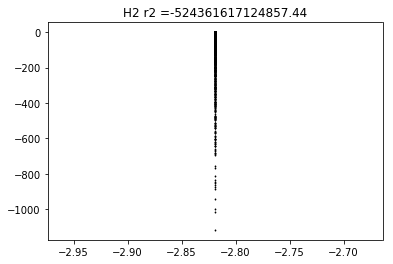

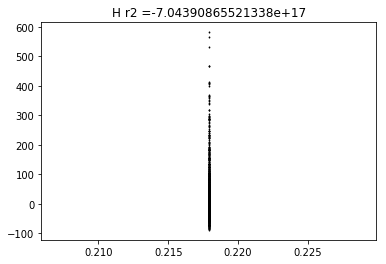

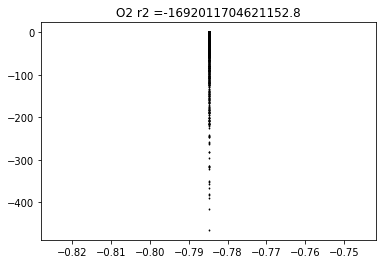

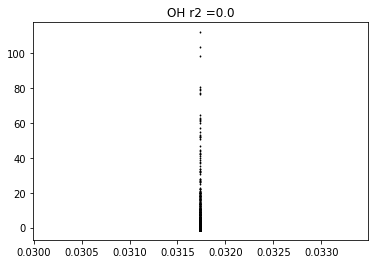

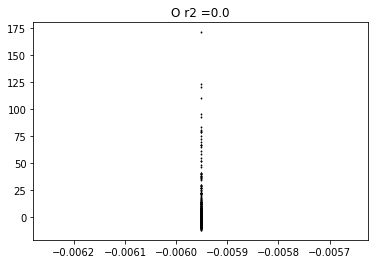

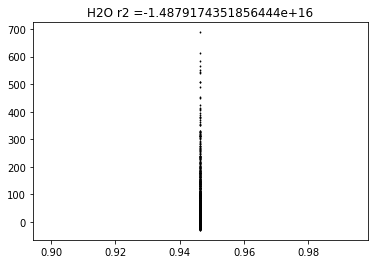

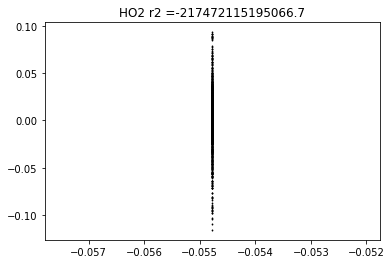

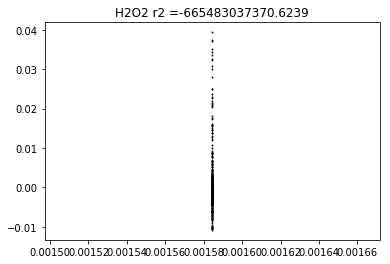

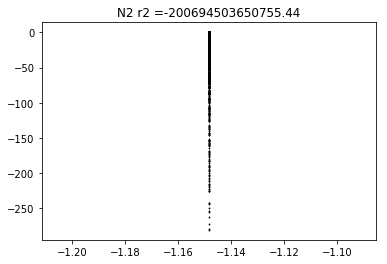

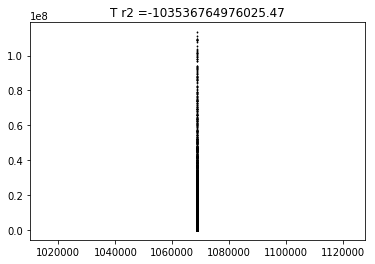

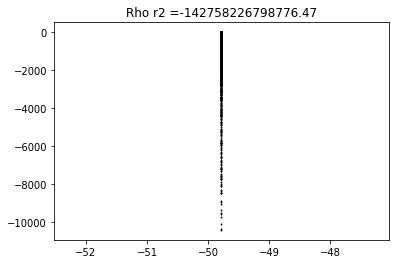

In [0]:
%matplotlib inline
spl_idx=pred_df.sample(frac=0.1).index
# sp='O'
for sp in labels:
  x=pred_df.sample(frac=0.1)
  plt.plot(pred_df.iloc[spl_idx][sp],test_df.iloc[spl_idx][sp],'kd',ms=1)
  plt.title('{} r2 ={}'.format(sp,r2_score(pred_df[sp],test_df[sp])))
  plt.show()

## Explicit methods
combine ODE solution method with neural netoworks. 
The Neural net work will produce the gradient evaluation and then ode numerial integration will be used. The easiest is the Euler method and the midpoint method should be more accurate. 


### Euler


In [0]:
def euler(data_in, dt):
  model_pred = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(data_in[input_features]),batch_size=1024*8)), columns=labels)

#   pred = model_pred * data_in+data_in
  pred = (model_pred)*dt +data_in
  
  return pred, model_pred

In [0]:
def adEuler(data_in, dt):
  st=100
  pred = data_in[input_features]
  for i in range(st):
#     print(i)
    model_pred = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(pred),batch_size=1024*8)), columns=labels)
    pred = (model_pred)*dt/st +pred
    
  return pred, (pred-data_in)/dt
    

[1.94241616e-05 5.95476481e-05 1.75221617e-04 1.32404646e-04
 1.34930023e-04 3.86406782e-05 2.41213889e-04 6.41769173e-04
 2.85438819e-05 8.03248891e-05 2.81254915e-05 2.85438860e-05
 2.92079424e-06]


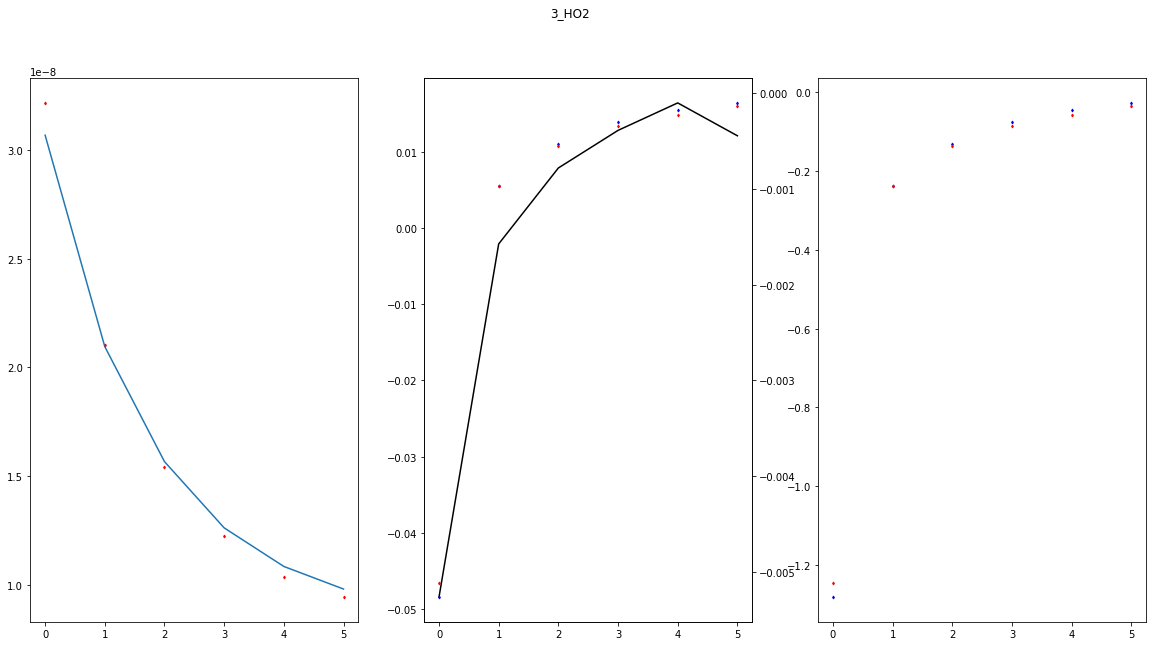

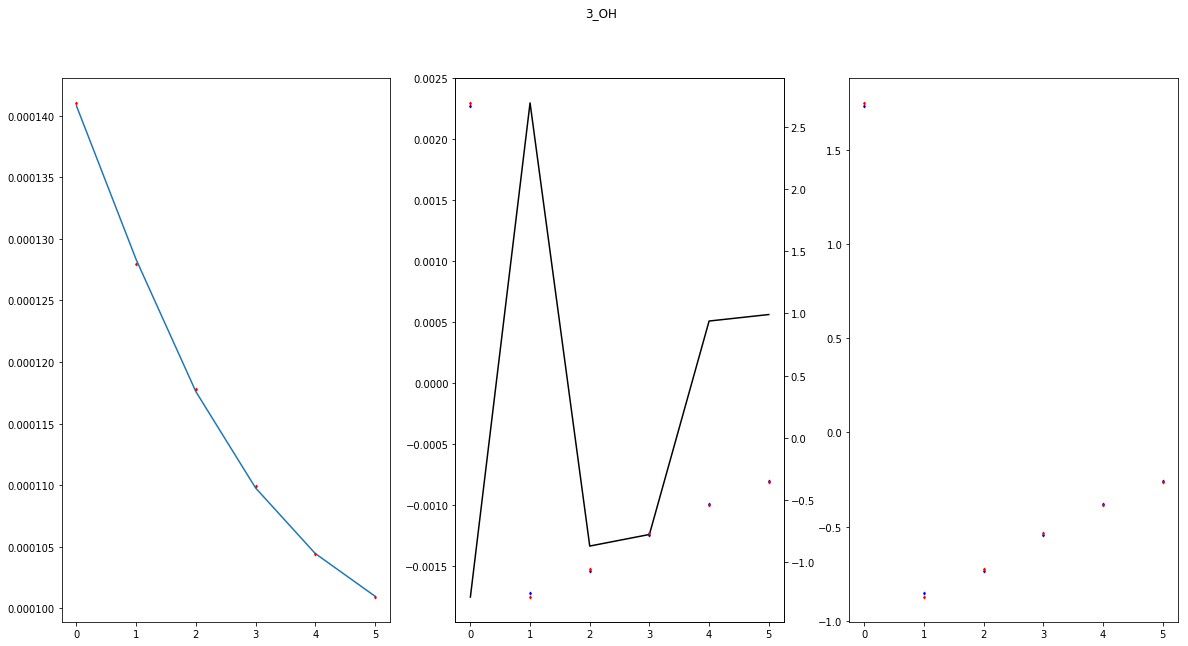

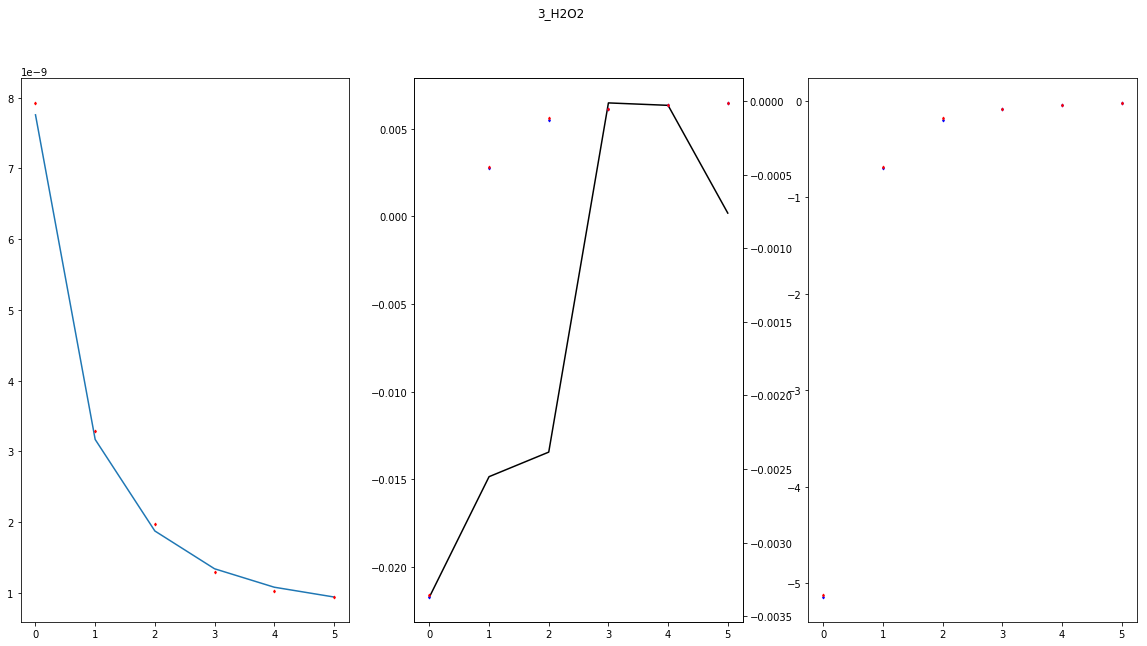

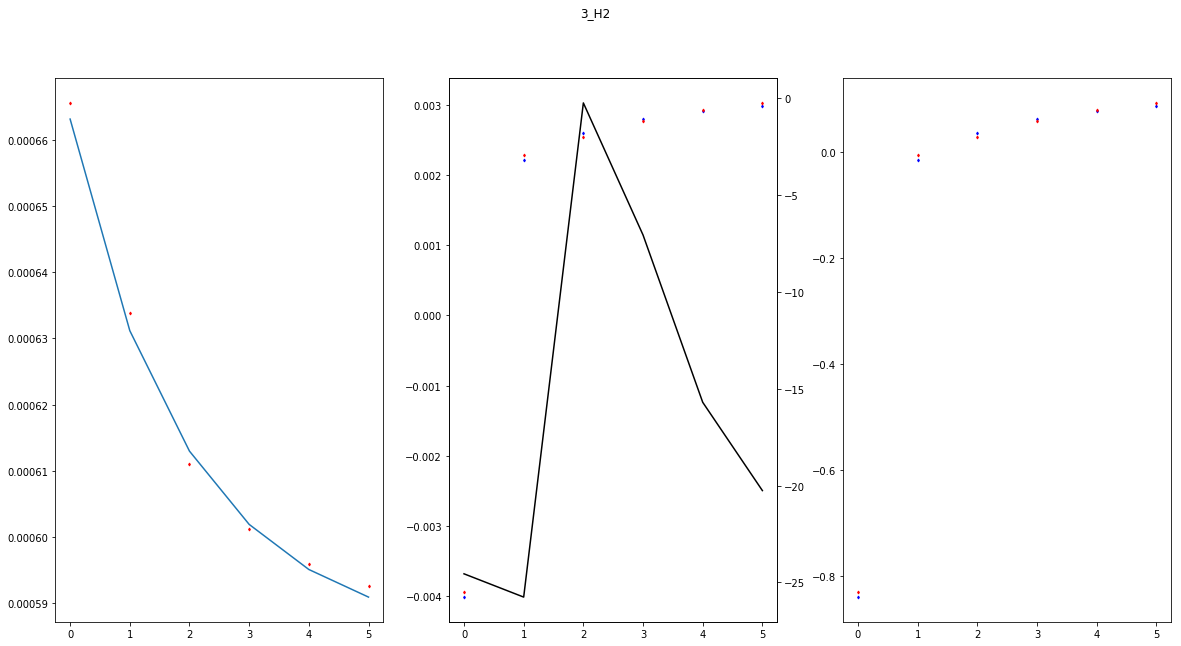

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]

columns=df.columns
species=df.columns

# post_species = species.drop(['cp', 'Hs', 'Rho','dt','f','N2'])

post_species=pd.Index(['HO2','OH','H2O2','H2'])

ini_T = 1601
dt = 1e-5
for n in [3]:
    input_0, test = test_data(ini_T, n, columns, dt)

    input_0=input_0.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
#     pred, model_pred=euler(input_0, dt)
    pred, model_pred=adEuler(input_0, dt)


    test_target = ((test-input_0) / dt)

    testGrad=pd.DataFrame(out_scaler.transform(test_target[labels]),columns=labels)
    trGrad=pd.DataFrame(out_scaler.transform(model_pred[labels]),columns=labels)
#         test_target = test
    for sp in post_species.intersection(species):
      f, axarr = plt.subplots(1, 3)
      f.suptitle(str(n) + '_' + sp)

      axarr[0].plot(test[sp])
      axarr[0].plot(pred[sp], 'rd', ms=2)
      # axarr[0].set_title(str(n) + '_' + sp)

#       axarr[1].plot((test[sp] - pred[sp]) / test[sp], 'k')
      axarr[1].plot((test[sp] - pred[sp])/test[sp].max(), 'k')

#         axarr[1].set_ylim(-0.005, 0.005)
      # axarr[1].set_title(str(n) + '_' + sp)

      ax2 = axarr[1].twinx()
      ax2.plot(test_target[sp], 'bd', ms=2)
      ax2.plot(model_pred[sp], 'rd', ms=2)
#       ax2.set_ylim(-0.0015,0.0015)
      
      axarr[2].plot(testGrad[sp], 'bd',ms=2)
      axarr[2].plot(trGrad[sp], 'rd',ms=2)
#       axarr[2].set_ylim(-0.1,0.)


#           ax2.plot(no_scaler[sp], 'md', ms=2)


#         plt.savefig('fig/' + str(n) + '_' + sp)
      plt.show()

In [0]:
trGrad['HO2']

### Adaptive rk

In [0]:
"""
Solve a constant pressure ignition problem where the governing equations are
implemented in Python.

This demonstrates an approach for solving problems where Cantera's reactor
network model cannot be configured to describe the system in question. Here,
Cantera is used for evaluating thermodynamic properties and kinetic rates while
an external ODE solver is used to integrate the resulting equations. In this
case, the SciPy wrapper for VODE is used, which uses the same variable-order BDF
methods as the Sundials CVODES solver used by Cantera.
"""

import cantera as ct
import numpy as np
import scipy.integrate

class odeNet:
    def __init__(self,name):
        self.name=name
    
    def __call__(self, t, x):
        """the ODE function, y' = f(t,y) """
        dydt = out_scaler.inverse_transform(model.predict(in_scaler.transform(x.reshape(1,-1))))

        return dydt

def odeInfer(data_in):

    t_end = 1e-7
    dt = 1e-7
    out_ode=[]
    for i in range(len(data_in)):
        x0=data_in[input_features].iloc[i:i+1]

        y0 = x0.values[0]
        ode = odeNet('wudi')
        solver = scipy.integrate.ode(ode)
        solver.set_integrator('vode', method='bdf', with_jacobian=True)
        solver.set_initial_value(y0, 0.0)
        while solver.successful() and solver.t < t_end:
            solver.integrate(solver.t + dt)
        out_ode.append(np.asarray(solver.y).reshape(1,-1))

    out=np.concatenate(out_ode)
    out = pd.DataFrame(out,columns=labels)

    return out

In [0]:
from scipy.integrate import odeint

def dydt(x,t):
  out = out_scaler.inverse_transform(model.predict(in_scaler.transform(x.reshape(1,-1))))
  return out.flatten()

def odeInt(data_in,dt):
  out_ode=[]
  for i in range(len(data_in)):
    x0=data_in[input_features].iloc[i:i+1]
    ode_out=odeint(
        dydt,
        x0.values[0],
        [0,dt]
    )
    out_ode.append(ode_out[1].reshape(1,-1))

  out=np.concatenate(out_ode)
  out = pd.DataFrame(out,columns=labels)
  
  return out

[4.67383430e-05 4.41047732e-05 2.00529738e-05 1.98554112e-05
 4.66832559e-05 7.11740855e-05 2.87307125e-05 8.66848990e-05
 5.82171911e-05 1.46810319e-04 5.60841337e-05 5.82171974e-05
 6.02966592e-06]


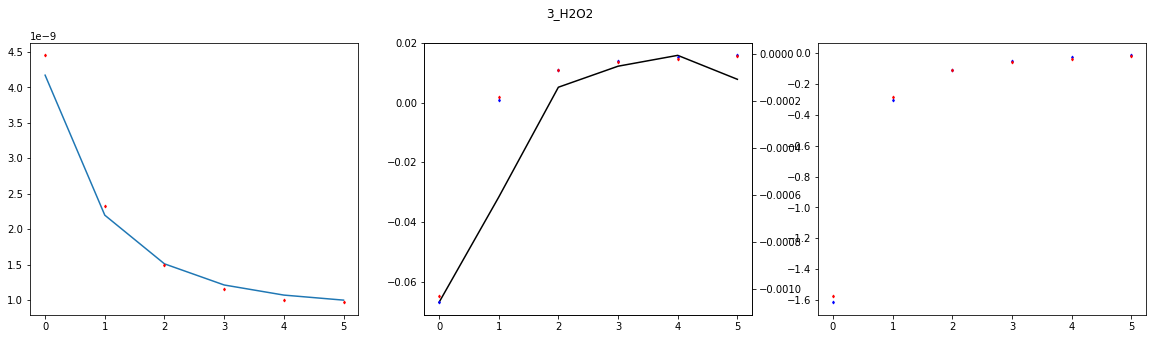

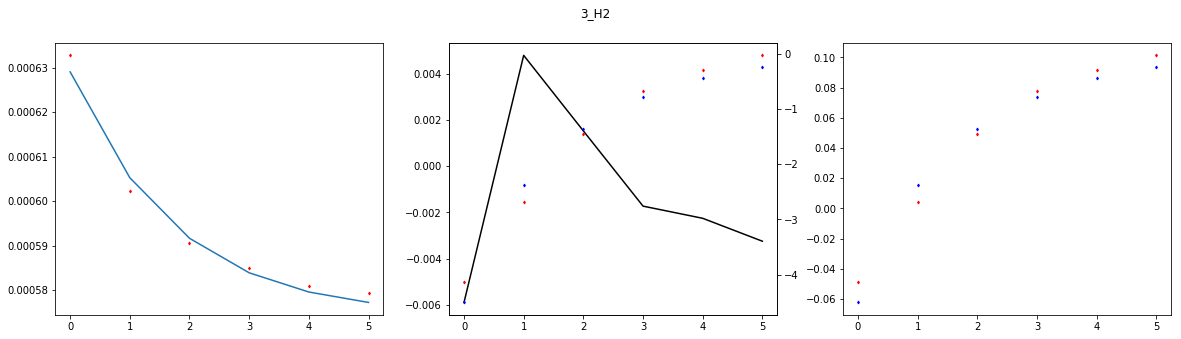

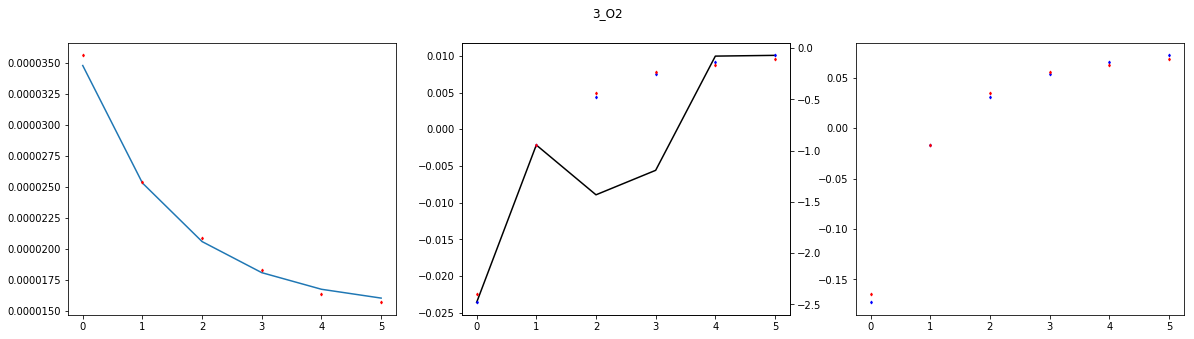

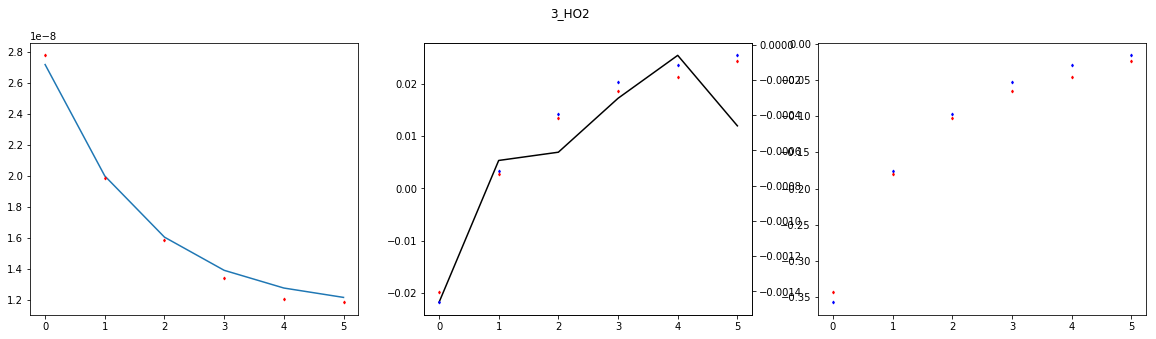

In [0]:
plt.rcParams['figure.figsize'] = [20, 5]

columns=df.columns
species=df.columns

# post_species = species.drop(['cp', 'Hs', 'Rho','dt','f','N2'])
# post_species = species.drop(['dt','f'])
post_species=pd.Index(['H2O2','H2','O2','HO2'])

ini_T = 1801
dt = 1e-5
for n in [3]:
    input_0, test = test_data(ini_T, n, columns, dt)

    input_0=input_0.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    no_scaler=pd.DataFrame(model.predict(in_scaler.transform(input_0[input_features])),columns=labels)

    pred = odeInt(input_0,dt)
#     pred = odeInfer(input_0)
    model_pred = (pred-input_0) /dt

    test_target = ((test-input_0) / dt)

    testGrad=pd.DataFrame(out_scaler.transform(test_target[labels]),columns=labels)
    trGrad=pd.DataFrame(out_scaler.transform(model_pred[labels]),columns=labels)

#     pred = pred * input
#     test_target = (test) / input

#         test_target = test
    for sp in post_species.intersection(species):
      f, axarr = plt.subplots(1, 3)
      f.suptitle(str(n) + '_' + sp)

      axarr[0].plot(test[sp])
      axarr[0].plot(pred[sp], 'rd', ms=2)
      # axarr[0].set_title(str(n) + '_' + sp)

      axarr[1].plot((test[sp] - pred[sp]) / test[sp].max(), 'k')
#         axarr[1].set_ylim(-0.005, 0.005)
      # axarr[1].set_title(str(n) + '_' + sp)

      ax2 = axarr[1].twinx()
      ax2.plot(test_target[sp], 'bd', ms=2)
      ax2.plot(model_pred[sp], 'rd', ms=2)

      axarr[2].plot(testGrad[sp], 'bd',ms=2)
      axarr[2].plot(trGrad[sp], 'rd',ms=2)

#           ax2.plot(no_scaler[sp], 'md', ms=2)


#         plt.savefig('fig/' + str(n) + '_' + sp)
      plt.show()

In [0]:
testGrad=pd.DataFrame(out_scaler.transform(test_target[labels]),columns=labels)
abs(testGrad).describe()

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp
count,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000
mean,0.542634,0.581731,0.557920,0.730041,0.895811,0.551883,0.243016,0.661929,0.525249,1.156168,0.734240,0.522049,0.479577
std,1.016513,1.080666,1.369943,2.147987,2.158665,1.228108,0.490333,1.787311,0.735865,1.441104,0.946525,0.717686,0.400335
min,0.026789,0.015047,0.002539,0.003965,0.007652,0.010904,0.047434,0.002288,0.000177,0.000163,0.000529,0.001167,0.001328
25%,0.338793,0.229376,0.264387,0.248726,0.202752,0.294231,0.066531,0.089106,0.180170,0.161999,0.178952,0.186565,0.312793
50%,0.357569,0.281949,0.306509,0.283030,0.324387,0.295956,0.104285,0.129308,0.293323,0.484746,0.318729,0.302239,0.450124
75%,0.367186,0.466146,0.321851,0.313004,0.685528,0.316154,0.163443,0.374745,0.388138,1.590252,0.855991,0.383176,0.511422
max,7.904273,8.425344,10.130864,15.709322,15.853757,9.363506,3.572265,14.597702,3.623605,5.973215,4.043057,3.556261,2.825173


In [0]:
trGrad=pd.DataFrame(out_scaler.transform(model_pred[labels]),columns=labels)
abs(trGrad).describe()

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp
count,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000
mean,0.613572,0.748515,0.560476,0.792762,1.051841,0.642025,0.519714,1.168994,0.599521,1.286957,0.973481,0.572542,0.453885
std,1.010052,1.033708,1.373703,2.179728,2.123483,1.214744,0.488855,1.653505,0.703968,1.350993,0.825397,0.692850,0.400967
min,0.012813,0.003067,0.002617,0.003596,0.001217,0.028135,0.000779,0.001335,0.012180,0.032175,0.035660,0.011880,0.002506
25%,0.395875,0.508593,0.247009,0.264645,0.506944,0.381786,0.178685,0.717343,0.302842,0.454956,0.494914,0.276764,0.300977
50%,0.426810,0.517461,0.320780,0.371976,0.519568,0.427202,0.403702,0.883232,0.325808,0.605565,0.642118,0.309924,0.367563
75%,0.495623,0.530225,0.329161,0.406167,0.682681,0.449094,0.779939,0.948223,0.396789,1.562823,0.965867,0.387128,0.468246
max,8.045688,8.562586,10.161571,16.396505,16.404679,9.426588,3.493878,14.399549,3.732517,5.993443,4.057873,3.616471,2.814935


### Midpoint

In [0]:
def rk2(data_in, dt):
  data_in=data_in.reset_index(drop=True)

  pred_0 = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(data_in[input_features]),batch_size=1024*8)), columns=labels)

#   mid=pred_0*data_in/2+data_in
#   mid['dt']=data_in['dt']
  mid = pred_0*dt/2+data_in
  model_pred = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(mid[input_features]),batch_size=1024*8)), columns=labels)

#   pred = model_pred * data_in+data_in
  pred = model_pred *dt +data_in
  
  return pred,model_pred

[1.74475880e-04 6.03815497e-04 9.94161344e-04 5.21167933e-04
 5.55604745e-04 7.68540238e-05 7.78644560e-04 2.22576820e-04
 1.56156716e-04 2.23821793e-04 1.77284887e-04 1.56156972e-04
 1.81369027e-05]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.


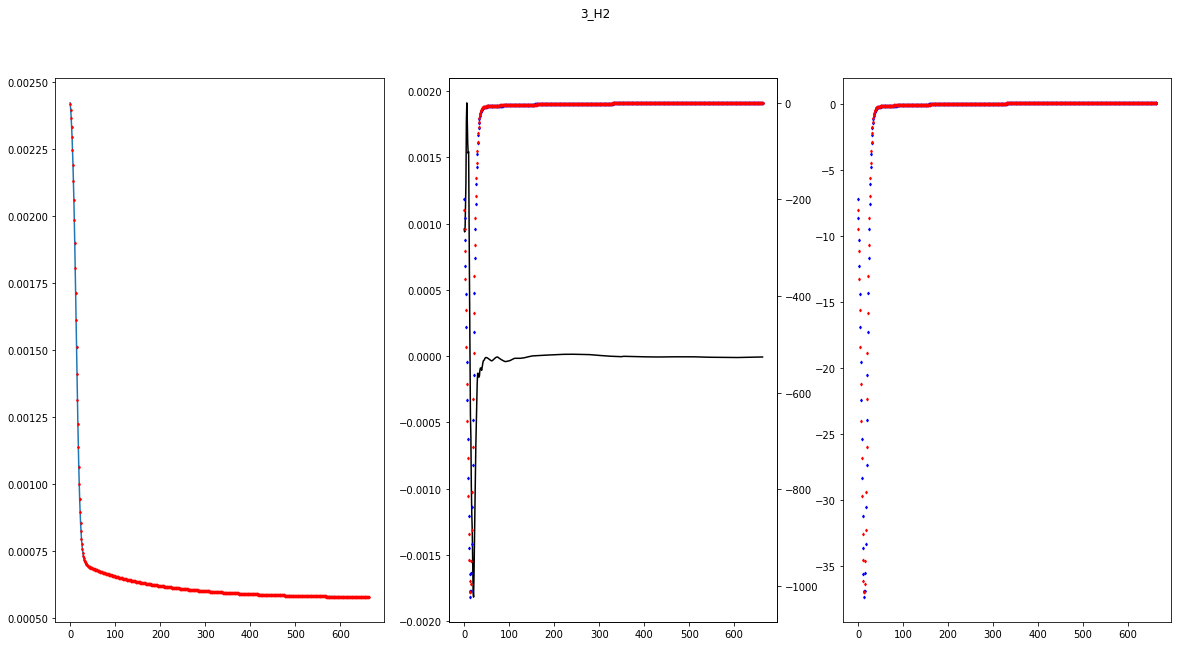

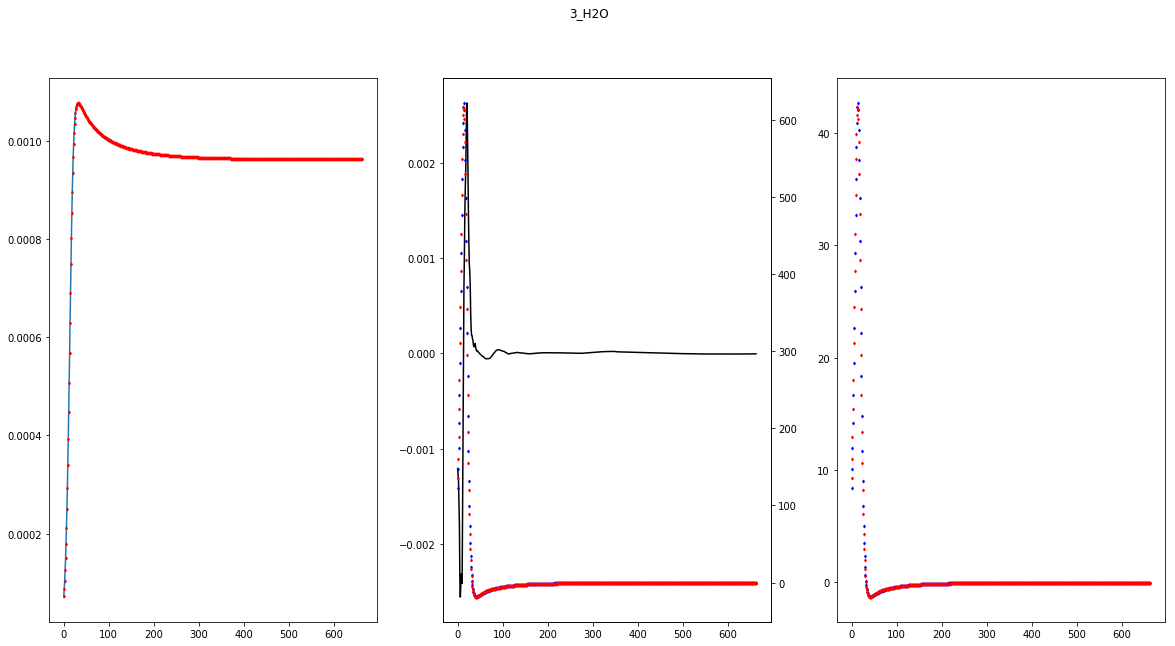

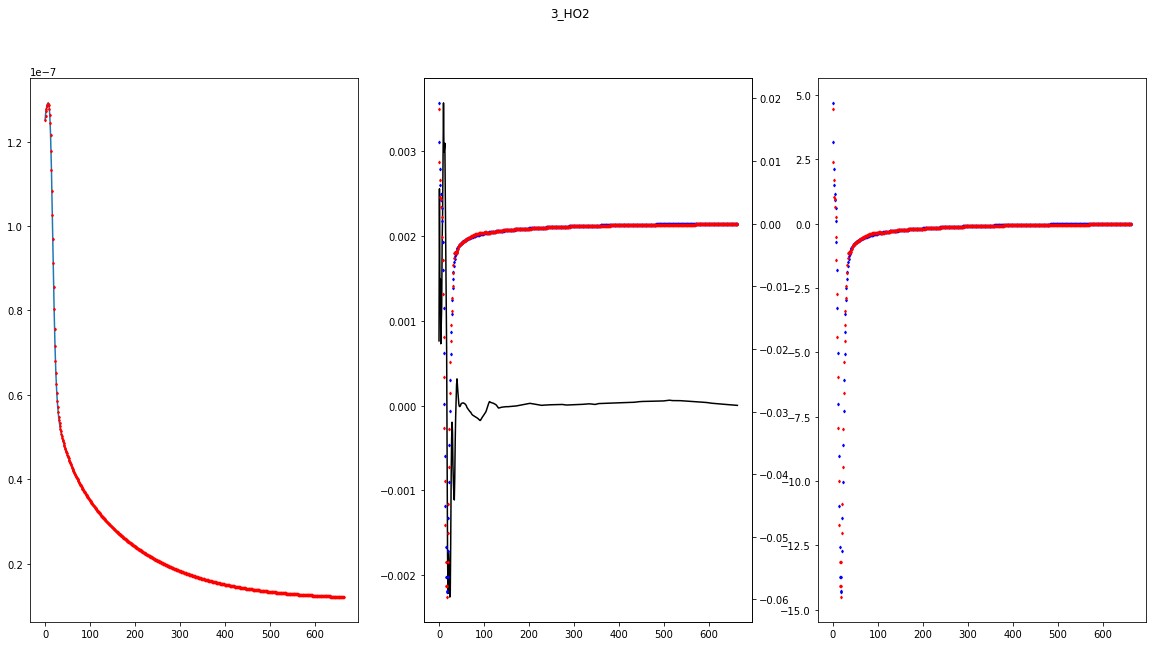

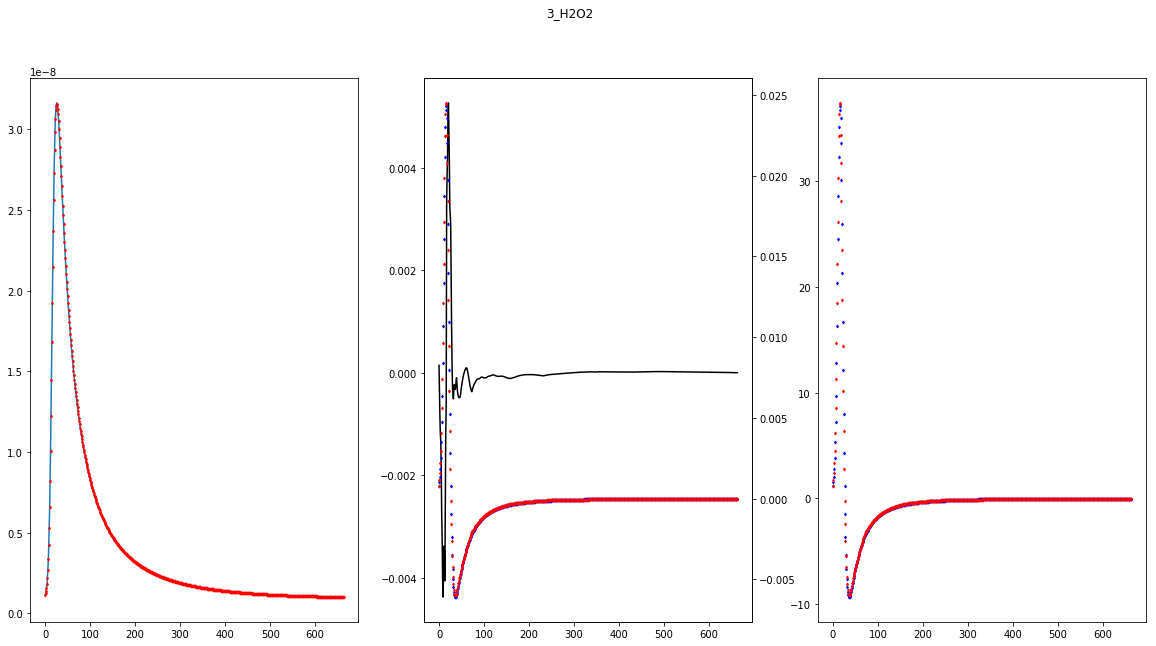

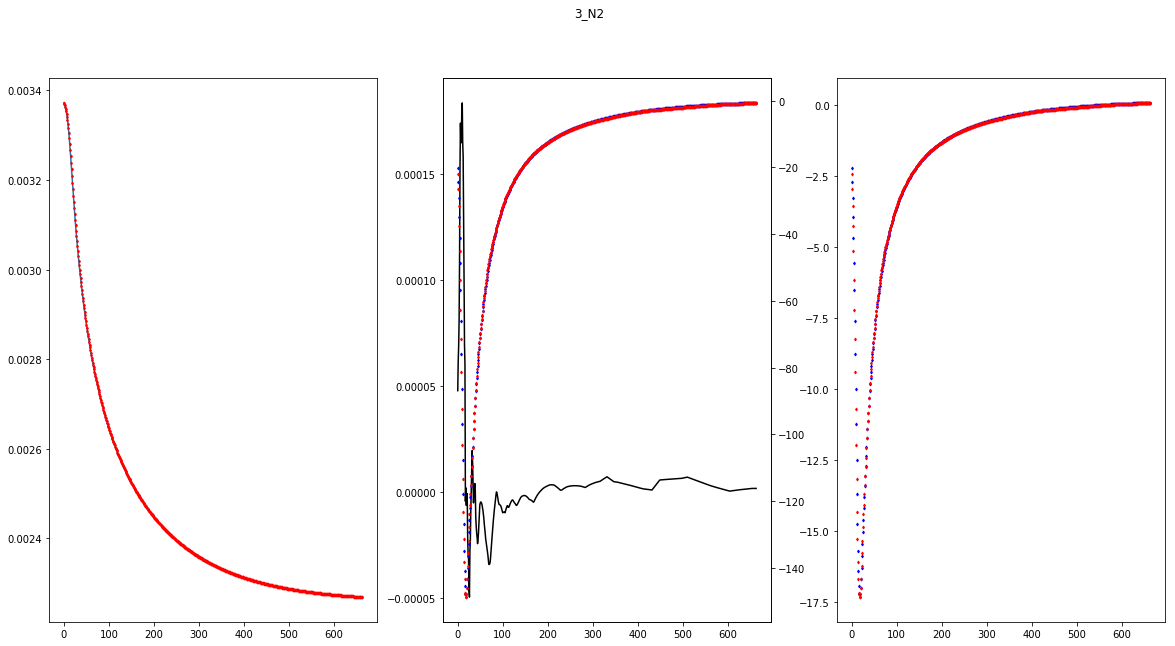

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]

columns=df.columns
species=df.columns

# post_species = species.drop(['cp', 'Hs', 'Rho','dt','f','N2'])

post_species=pd.Index(['H2','H2O','HO2','H2O2','N2'])

ini_T = 1801
dt = 1e-7
for n in [3]:
    input_0, test = test_data(ini_T, n, columns, dt)
    
    input_0=input_0.reset_index(drop=True)
    test = test.reset_index(drop=True)

    no_scaler=pd.DataFrame(model.predict(in_scaler.transform(input_0[input_features])),columns=labels)
    
    pred,model_pred = rk2(input_0, dt)
    test_target = (test-input_0) / dt


    testGrad=pd.DataFrame(out_scaler.transform(test_target[labels]),columns=labels)
    trGrad=pd.DataFrame(out_scaler.transform(model_pred[labels]),columns=labels)
#         test_target = test
    for sp in post_species.intersection(species):
      f, axarr = plt.subplots(1, 3)
      f.suptitle(str(n) + '_' + sp)

      axarr[0].plot(test[sp])
      axarr[0].plot(pred[sp], 'rd', ms=2)
      # axarr[0].set_title(str(n) + '_' + sp)

      axarr[1].plot((test[sp] - pred[sp]) / test[sp].max(), 'k')
#         axarr[1].set_ylim(-0.005, 0.005)
      # axarr[1].set_title(str(n) + '_' + sp)

      ax2 = axarr[1].twinx()
      ax2.plot(test_target[sp], 'bd', ms=2)
      ax2.plot(model_pred[sp], 'rd', ms=2)

      axarr[2].plot(testGrad[sp], 'bd',ms=2)
      axarr[2].plot(trGrad[sp], 'rd',ms=2)

#           ax2.plot(no_scaler[sp], 'md', ms=2)


#         plt.savefig('fig/' + str(n) + '_' + sp)
      plt.show()

### RK45


In [0]:
def rk4(data_in):
  p1=data_in
  k1 = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(p1[input_features]),batch_size=1024*8)), columns=labels)
  
  p2=k1*data_in/2+data_in
  p2['dt']=data_in['dt']

  k2 = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(p2[input_features]),batch_size=1024*8)), columns=labels)
  
  p3 =k2*data_in/2 +data_in
  p3['dt']=data_in['dt']
  
  k3 = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(p3[input_features]),batch_size=1024*8)), columns=labels)
  
  p4 =k3*data_in +data_in
  p4['dt']=data_in['dt']
  
  k4 = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(p4[input_features]),batch_size=1024*8)), columns=labels)
  
  model_pred = 1/6*(k1+2*k2+2*k3+k4)
  pred =data_in + model_pred*data_in
  return pred, model_pred


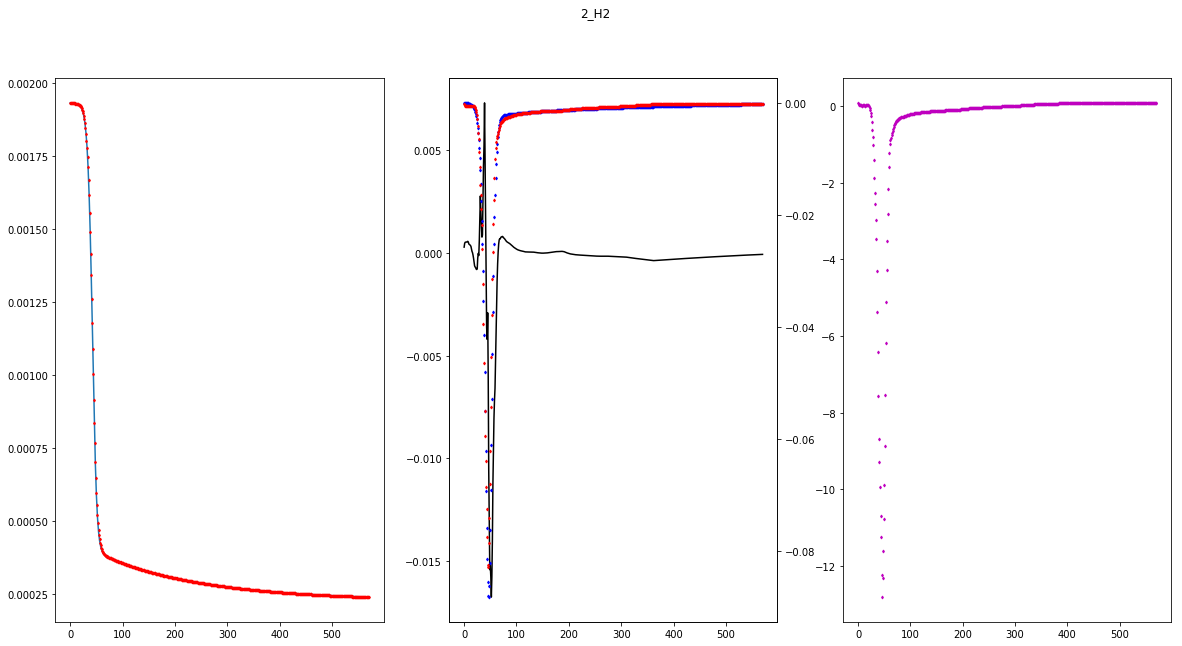

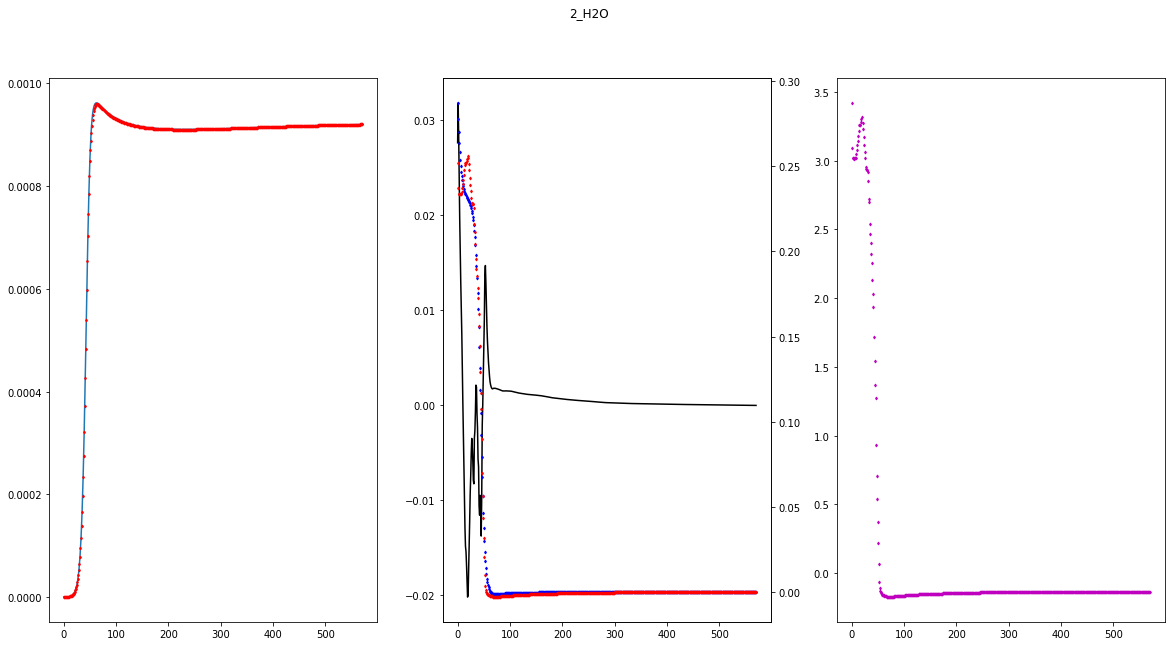

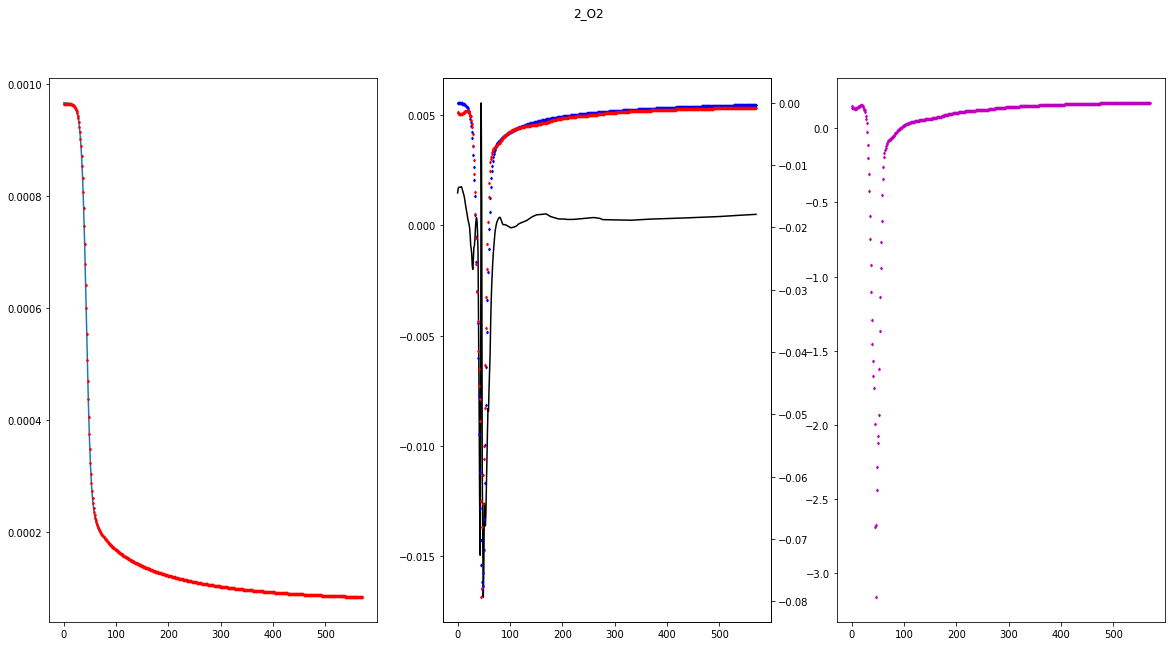

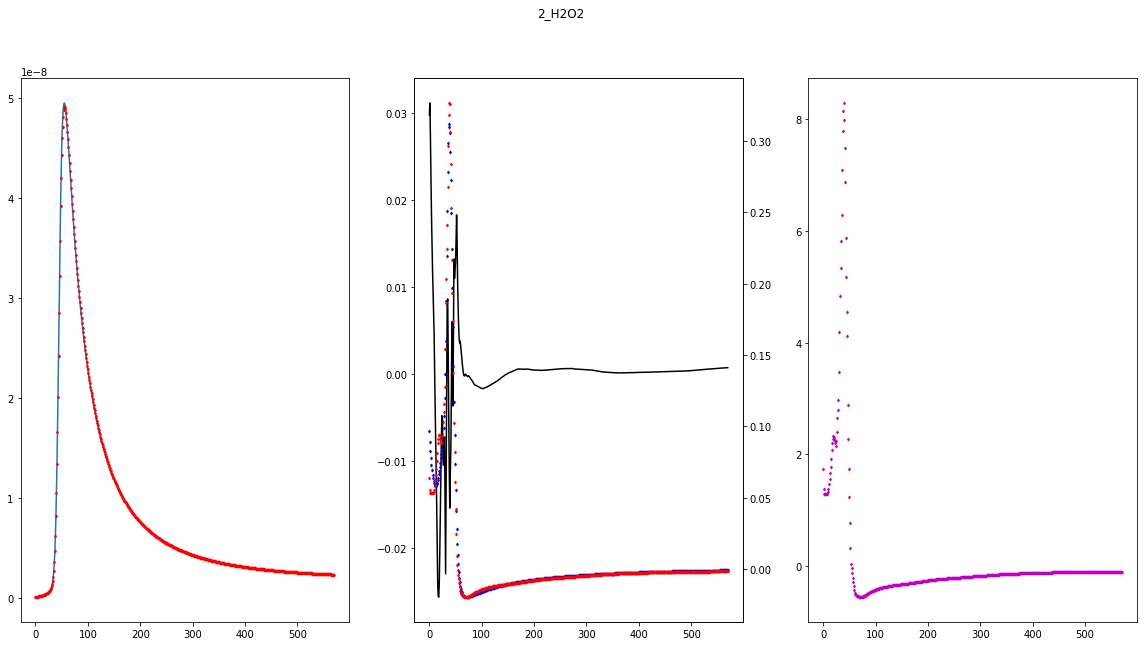

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]

columns=df.columns
species=df.columns

# post_species = species.drop(['cp', 'Hs', 'Rho','dt','f','N2'])

post_species=pd.Index(['H2','H2O','O2','H2O2'])

ini_T = 1801

for n in [2]:
    input_0, test = test_data(ini_T, n, columns)
    
    input_0=input_0.reset_index(drop=True)
    test = test.reset_index(drop=True)

    no_scaler=pd.DataFrame(model.predict(in_scaler.transform(input_0[input_features])),columns=labels)
    
    pred, model_pred= rk4(input_0)
    test_target = (test-input_0) / input_0


    for sp in post_species.intersection(species):
      f, axarr = plt.subplots(1, 3)
      f.suptitle(str(n) + '_' + sp)

      axarr[0].plot(test[sp])
      axarr[0].plot(pred[sp], 'rd', ms=2)
      # axarr[0].set_title(str(n) + '_' + sp)

      axarr[1].plot((test[sp] - pred[sp]) / test[sp], 'k')
#         axarr[1].set_ylim(-0.005, 0.005)
      # axarr[1].set_title(str(n) + '_' + sp)

      ax2 = axarr[1].twinx()
      ax2.plot(test_target[sp], 'bd', ms=2)
      ax2.plot(model_pred[sp], 'rd', ms=2)
#         ax2.set_ylim(0., 5)
#         ax2.plot(out_scaler.transform(test_target[sp]), 'bd', ms=2)
#         ax2.set_ylim(0., 5)
      axarr[2].plot(no_scaler[sp], 'md',ms=2)
#           ax2.plot(no_scaler[sp], 'md', ms=2)


#         plt.savefig('fig/' + str(n) + '_' + sp)
      plt.show()

In [0]:
%%time
all_in=df[0:int(df.shape[0]/2)]
_=model.predict(in_scaler.transform(all_in[input_features]),batch_size=1024*8*8)
all_in.shape

CPU times: user 2.56 s, sys: 1.24 s, total: 3.8 s
Wall time: 3.68 s


In [0]:
all_in.shape

(6086352, 15)

## Implicit method


### backward euler

In [0]:
def backward_euler(data_in):
  tol=1e-4
  evl=1
  model_pred = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(data_in[input_features]),batch_size=1024*8)), columns=labels)

  pred = model_pred * 2e-7+data_in
#   pred['dt'] = data_in['dt']
  
  while(evl>tol):
    updata = pd.DataFrame(out_scaler.inverse_transform(model.predict(in_scaler.transform(pred[input_features]),batch_size=1024*8)), columns=labels)

    pred_up = updata*2e-7 +data_in
#     pred_up['dt']=data_in['dt']

    evl=((pred_up - pred)/pred)[input_features].max().max()
    print(evl)

    pred = pred_up
  model_eqv=(pred-data_in)/data_in
  
  return pred, model_eqv

0.21795666402515937
0.06942494571896779
0.021988426764686247
0.005914282476821096
0.0022412403237962444
0.0007739322751783061
0.0002721219625206222
9.651501359929765e-05


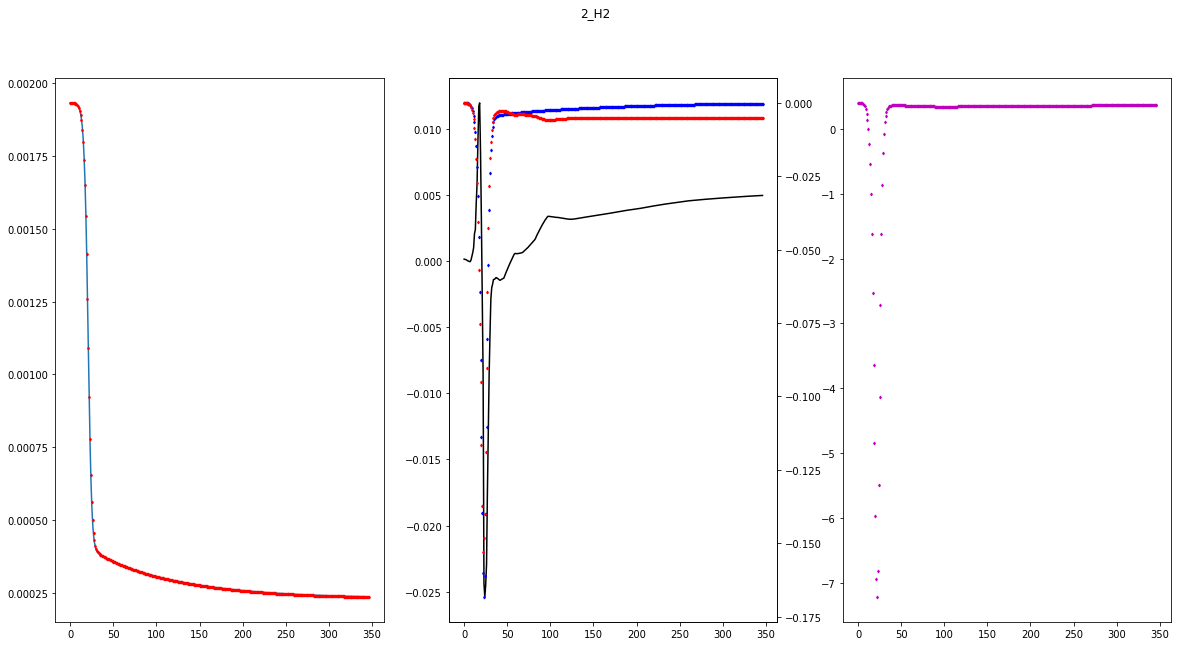

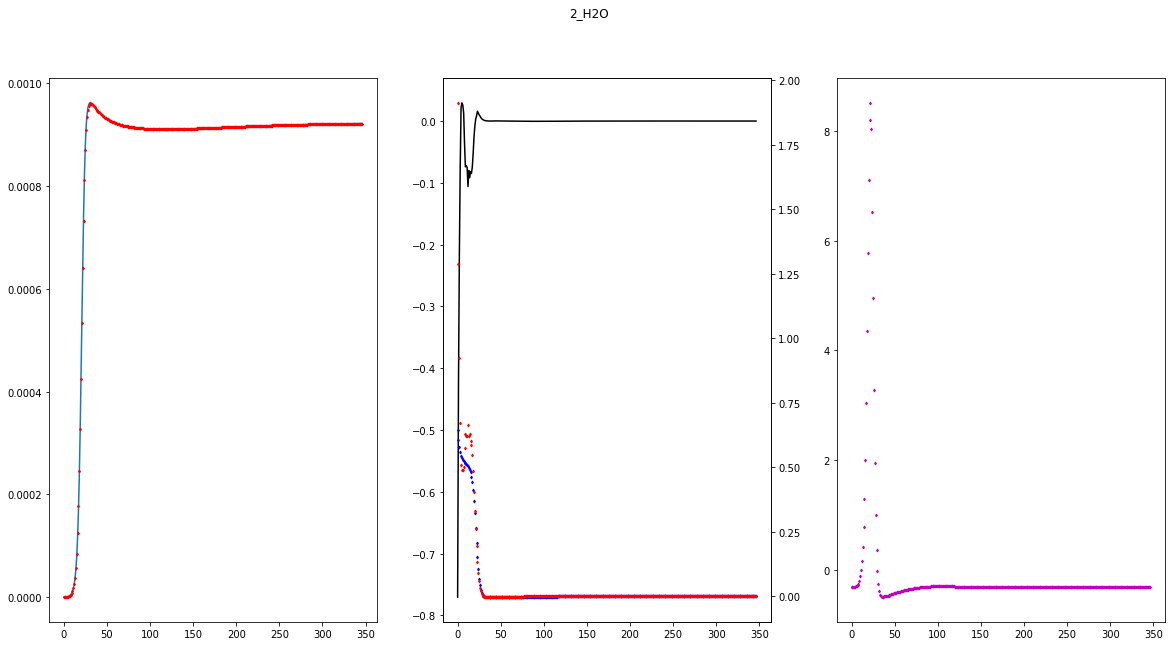

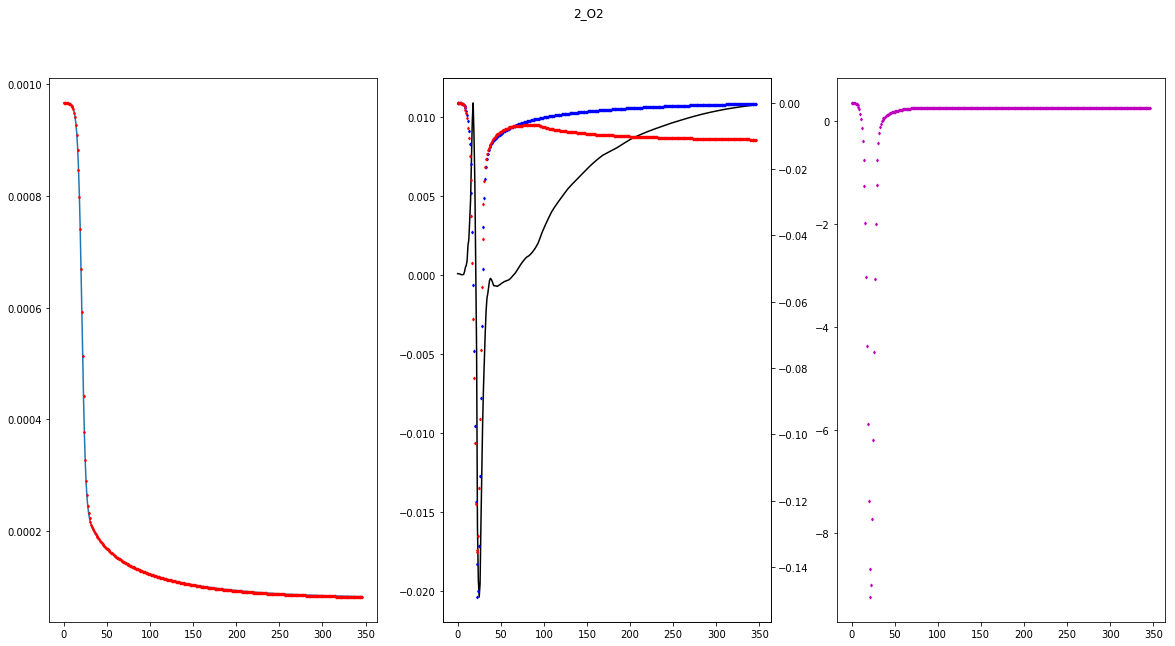

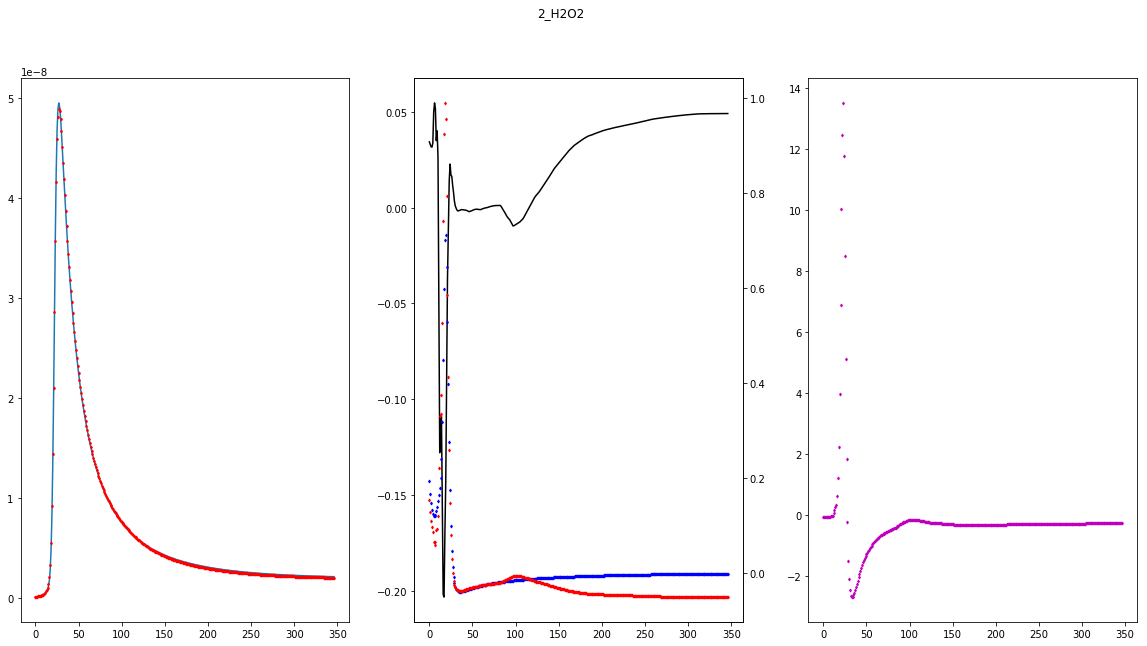

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]

columns=df.columns
species=df.columns

# post_species = species.drop(['cp', 'Hs', 'Rho','dt','f','N2'])

post_species=pd.Index(['H2','H2O','O2','H2O2'])

ini_T = 1801

for n in [2]:
    input_0, test = test_data(ini_T, n, columns)

    input_0=input_0.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    no_scaler=pd.DataFrame(model.predict(in_scaler.transform(input_0[input_features])),columns=labels)

    pred, model_pred=backward_euler(input_0)

    test_target = (test-input_0) / input_0

#     pred = pred * input
#     test_target = (test) / input

#         test_target = test
    for sp in post_species.intersection(species):
      f, axarr = plt.subplots(1, 3)
      f.suptitle(str(n) + '_' + sp)

      axarr[0].plot(test[sp])
      axarr[0].plot(pred[sp], 'rd', ms=2)
      # axarr[0].set_title(str(n) + '_' + sp)

      axarr[1].plot((test[sp] - pred[sp]) / test[sp], 'k')
#         axarr[1].set_ylim(-0.005, 0.005)
      # axarr[1].set_title(str(n) + '_' + sp)

      ax2 = axarr[1].twinx()
      ax2.plot(test_target[sp], 'bd', ms=2)
      ax2.plot(model_pred[sp], 'rd', ms=2)
#         ax2.set_ylim(0., 5)
#         ax2.plot(out_scaler.transform(test_target[sp]), 'bd', ms=2)
#         ax2.set_ylim(0., 5)
      axarr[2].plot(no_scaler[sp], 'md',ms=2)
#           ax2.plot(no_scaler[sp], 'md', ms=2)


#         plt.savefig('fig/' + str(n) + '_' + sp)
      plt.show()

## integration test

In [0]:
x0=input_0[input_features].iloc[0:1]
x_out=pd.DataFrame()
x_out=pd.concat([x_out,x0],sort=False)
for i in range(300):
  xi,_=euler(x0)
  xi['dt']=1e-7
  x0=xi
  x_out=pd.concat([x_out,xi],sort=False)

x_out=x_out.reset_index(drop=True)

NameError: ignored

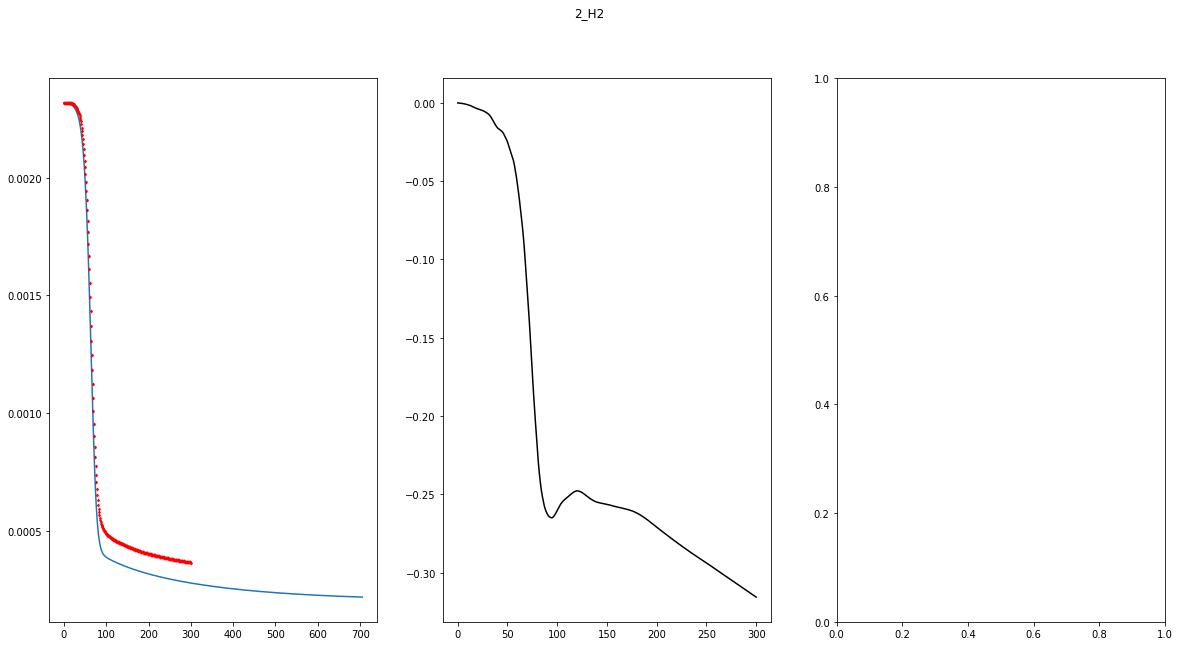

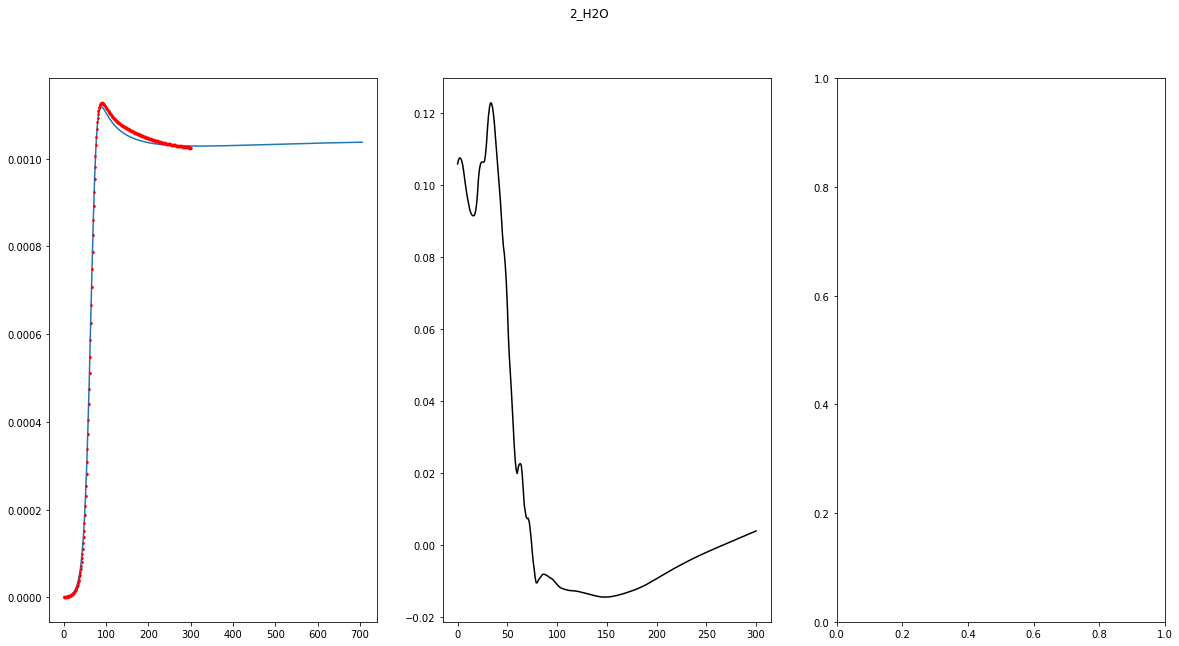

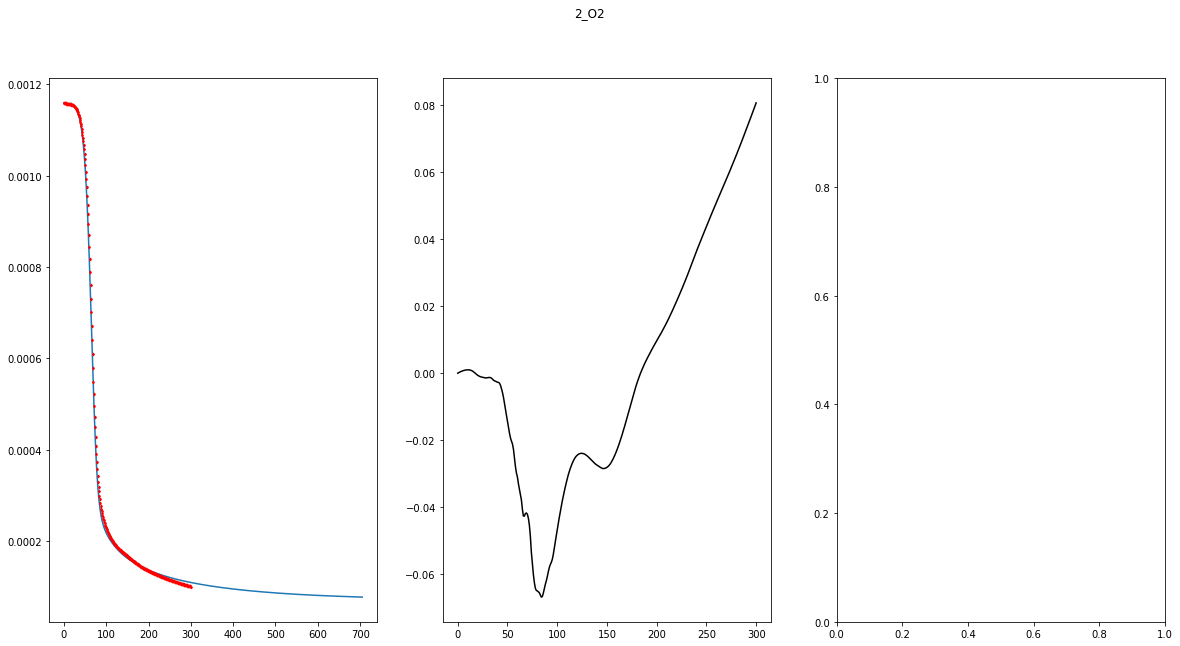

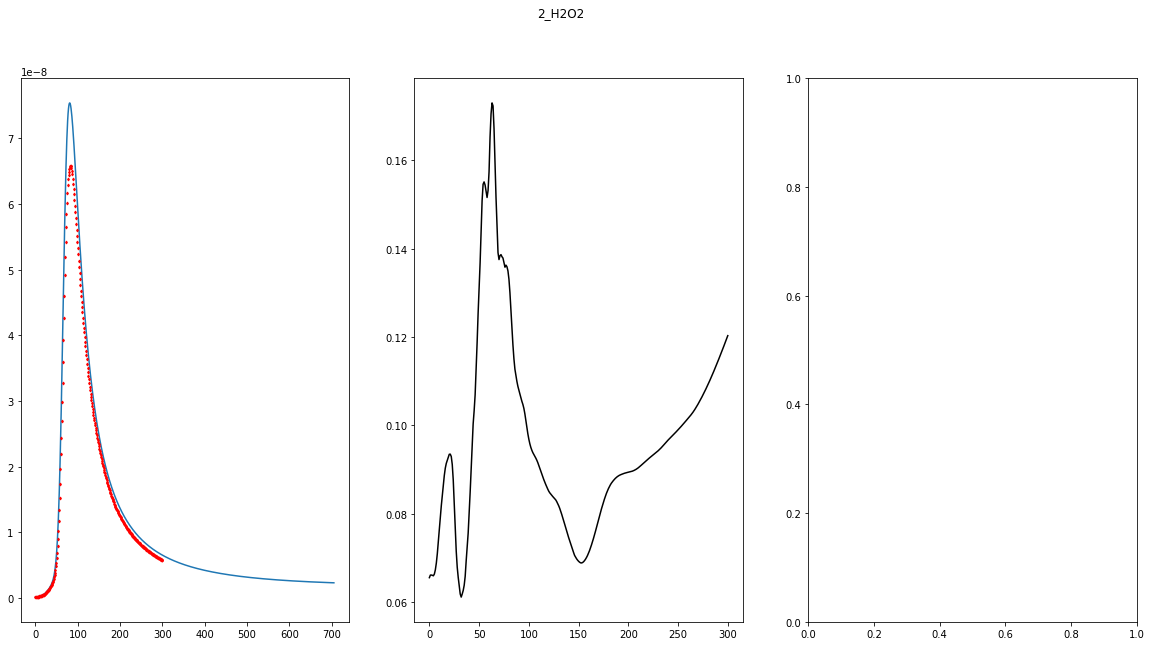

In [0]:
plt.rcParams['figure.figsize'] = [20, 10]

columns=df.columns
species=df.columns

# post_species = species.drop(['cp', 'Hs', 'Rho','dt','f','N2'])

post_species=pd.Index(['H2','H2O','O2','H2O2'])

ini_T = 1501

for n in [2]:
    input_0, test = test_data(ini_T, n, columns)

    input_0=input_0.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    no_scaler=pd.DataFrame(model.predict(in_scaler.transform(input_0[input_features])),columns=labels)

    pred = x_out



#     pred = pred * input
#     test_target = (test) / input

#         test_target = test
    for sp in post_species.intersection(species):
      f, axarr = plt.subplots(1, 3)
      f.suptitle(str(n) + '_' + sp)

      axarr[0].plot(test[sp])
      axarr[0].plot(pred[sp], 'rd', ms=2)
      # axarr[0].set_title(str(n) + '_' + sp)

      axarr[1].plot((test[sp] - pred[sp]) / test[sp], 'k')
#         axarr[1].set_ylim(-0.005, 0.005)
      # axarr[1].set_title(str(n) + '_' + sp)


      plt.show()

In [0]:
x_out

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp,dt
0,0.001933,9.059264e-08,0.000967,1.528460e-08,1.311471e-08,8.329337e-08,1.973417e-08,1.038378e-10,0.003867,4.859374e+07,1800.984838,0.143148,1666.225754,1.000000e-07
0,0.001934,1.141849e-07,0.000968,1.935818e-08,1.659144e-08,1.080260e-07,2.168659e-08,1.165464e-10,0.003867,4.859277e+07,1801.098675,0.143159,1666.259665,1.000000e-07
0,0.001934,1.436247e-07,0.000970,2.446438e-08,2.094685e-08,1.397976e-07,2.380643e-08,1.306549e-10,0.003868,4.859180e+07,1801.218793,0.143169,1666.294388,1.000000e-07
0,0.001935,1.802378e-07,0.000971,3.084271e-08,2.638491e-08,1.804725e-07,2.610207e-08,1.462773e-10,0.003869,4.859083e+07,1801.345820,0.143178,1666.329963,1.000000e-07
0,0.001935,2.256016e-07,0.000973,3.877944e-08,3.314911e-08,2.323484e-07,2.858059e-08,1.635273e-10,0.003869,4.858985e+07,1801.478478,0.143186,1666.366289,1.000000e-07
0,0.001936,2.816716e-07,0.000974,4.862904e-08,4.154099e-08,2.983296e-07,3.125147e-08,1.825421e-10,0.003870,4.858887e+07,1801.617941,0.143192,1666.403495,1.000000e-07
0,0.001936,3.507630e-07,0.000975,6.081453e-08,5.192130e-08,3.819938e-07,3.412181e-08,2.034523e-10,0.003871,4.858788e+07,1801.765957,0.143198,1666.441793,1.000000e-07
0,0.001936,4.356285e-07,0.000976,7.584162e-08,6.472183e-08,4.877460e-07,3.719732e-08,2.263882e-10,0.003871,4.858688e+07,1801.924323,0.143202,1666.481412,1.000000e-07
0,0.001937,5.394482e-07,0.000976,9.429641e-08,8.044404e-08,6.208766e-07,4.048107e-08,2.514631e-10,0.003872,4.858587e+07,1802.094111,0.143205,1666.522442,1.000000e-07
0,0.001937,6.659293e-07,0.000976,1.168645e-07,9.967558e-08,7.877875e-07,4.397391e-08,2.787840e-10,0.003872,4.858485e+07,1802.276732,0.143206,1666.564992,1.000000e-07


In [0]:
pd.concat([x0,xi],sort=False)

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp,dt
0,0.001933,9.059264e-08,0.000967,1.528460e-08,1.311471e-08,8.329337e-08,1.973417e-08,1.038378e-10,0.003867,4.859374e+07,1800.984838,0.143148,1666.225754,1.000000e-07
0,0.001933,1.128075e-07,0.000967,1.906487e-08,1.636358e-08,1.073961e-07,2.116044e-08,1.140718e-10,0.003867,4.859383e+07,1800.972702,0.143147,1666.218103,1.000000e-07


In [0]:
a,b=euler(x0)

In [0]:
a

,H,H2,H2O,H2O2,HO2,Hs,N2,O,O2,OH,Rho,T,cp,dt
0,1.128075e-07,0.001933,1.073961e-07,1.140718e-10,2.116044e-08,4.859383e+07,0.003867,1.636358e-08,0.000967,1.906487e-08,0.143147,1800.972702,1666.218103,NaN


In [0]:
b

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp
0,-0.000079,0.245217,0.000495,0.247326,0.247728,0.289371,0.072274,0.098557,-7.962760e-07,0.000002,-0.000007,-7.962611e-07,-0.000005


In [0]:
x0

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp,dt
0,0.001933,9.059264e-08,0.000967,1.528460e-08,1.311471e-08,8.329337e-08,1.973417e-08,1.038378e-10,0.003867,4.859374e+07,1800.984838,0.143148,1666.225754,1.000000e-07


# TODO

## Scale first then transform
histogram plot

In [0]:
model.save('trained_fgm_nn.h5')

In [0]:
out=pd.DataFrame(y_label,columns=labels)
out.describe()

,H2,H,O2,OH,O,H2O,HO2,H2O2,N2,Hs,T,Rho,cp
count,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06,3.153361e+06
mean,4.937420e-15,-1.415935e-16,3.802062e-15,2.605576e-15,-8.193816e-15,6.745485e-15,-1.566364e-15,-9.494692e-16,4.206316e-15,-3.665330e-15,3.539245e-15,-3.788133e-15,-9.678081e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.036314e+01,-1.878374e+00,-1.217757e+01,-4.097174e-01,-1.695543e+00,-7.957705e-01,-2.226410e+01,-3.830703e+00,-7.359140e+00,-5.153498e-01,-7.234939e-01,-7.254611e+00,-6.722872e-01
25%,1.480273e-01,-2.548324e-01,1.690783e-01,-2.165622e-01,-1.212132e-01,-3.304367e-01,-1.686652e-01,-9.415260e-02,1.201116e-01,-4.997650e-01,-5.573426e-01,9.578917e-02,-6.344906e-01
50%,3.623018e-01,-2.119812e-01,3.572663e-01,-2.162432e-01,-1.203322e-01,-3.285663e-01,-3.509272e-02,-7.624271e-02,4.083632e-01,-4.650425e-01,-4.694636e-01,4.108179e-01,-4.716093e-01
75%,4.161285e-01,-1.144061e-01,3.690463e-01,-1.886424e-01,-1.113902e-01,-1.740516e-01,1.593966e-01,-3.567304e-02,4.481328e-01,-1.219001e-01,-1.023262e-02,4.601997e-01,2.472389e-01
max,5.037157e-01,1.214499e+01,4.634036e-01,2.580428e+01,2.621408e+01,1.187069e+01,7.377041e+00,1.648982e+01,6.502520e-01,5.951113e+00,5.539411e+00,6.554077e-01,6.290042e+00


##  Transformation $1=\frac{x}{(1+|x|)}$ 

In [0]:
def y(x):
  return x/(1+abs(x))